# **Publication Figures**

Goal: rebuild camera-ready figures from existing artifacts without re-running optimizations.
Quickstart: edit the Artifact Selector, run all cells, then collect the exported figures listed at the end.

Sections:
- [Artifact Selector](#Artifact-Selector)
- [Load Artifacts](#Load-Artifacts)
- [Standard Figures](#Standard-Figures)
- [Penalty History](#Penalty-History)
- [High-Resolution Robustness](#High-Resolution-Robustness)
- [Export Summary](#Export-Summary)
- [Troubleshooting](#Troubleshooting)


## Imports


In [1]:
# Imports
from pathlib import Path
import json
import shutil
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import sys, os


# Assume this notebook lives in project_root/notebooks/
repo_root = Path(__file__).resolve().parents[1] if "__file__" in globals() else Path.cwd().parent
sys.path.insert(0, str(repo_root))
os.chdir(repo_root)

print("Using repo root:", repo_root)
from src import (
    ExperimentConfig,
    Result,
    plot_cost_history,
    plot_pulses,
    plot_summary,
    plot_penalties_history,
    plot_robustness_heatmap,
)
from src.optimizers.base import load_crab_problem
from src.cost import accumulate_cost_and_grads


Using repo root: c:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB


## Artifact Selector


In [2]:
# @title Artifact Selector
ARTIFACT_GLOBS = [
    'results/optimizer_comparison/*',
]
OUTPUT_DIR = Path('results/publication_figures').resolve()
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR = OUTPUT_DIR / 'figures'
FIGURES_DIR.mkdir(parents=True, exist_ok=True)


## Load Artifacts


In [3]:
# @title Load Artifacts
artifact_dirs = []
for pattern in ARTIFACT_GLOBS:
    for path in sorted(Path('.').glob(pattern)):
        if path.is_dir() and (path / 'config.json').exists():
            artifact_dirs.append(path.resolve())

print('Artifacts discovered:')
for path in artifact_dirs:
    print(' ', path)

loaded_results = {}
for path in artifact_dirs:
    # Rehydrate configs and arrays so downstream plotting can reuse helper functions.
    cfg = ExperimentConfig.from_dict(json.loads(path.joinpath('config.json').read_text()))
    metrics = json.loads(path.joinpath('metrics.json').read_text())
    history_npz = np.load(path.joinpath('history.npz'))
    history = {key: history_npz[key] for key in history_npz.files}
    pulses_npz = np.load(path.joinpath('pulses.npz'))
    pulses = {key: pulses_npz[key] for key in pulses_npz.files}
    result = Result(
        run_name=cfg.run_name or path.name,
        artifacts_dir=path,
        config=cfg,
        history=history,
        final_metrics=metrics,
        pulses=pulses,
        optimizer_state={},
    )
    loaded_results[path.name] = result

print('Loaded results:')
for name, result in loaded_results.items():
    objective = result.config.metadata.get('objective', 'terminal')
    print(f"  {name}: objective={objective} -> {result.artifacts_dir}")

# Reference baseline used for comparisons when plotting robustness figures.
baseline_problem, _, _ = load_crab_problem(ExperimentConfig.from_dict({
    'baseline': {'name': 'default'},
    'optimizer_options': {},
    'penalties': {'power_weight': 0.0, 'neg_weight': 0.0, 'neg_kappa': 10.0},
}))
omega_baseline = baseline_problem.omega_base
if baseline_problem.delta_base is None:
    delta_baseline = np.zeros_like(omega_baseline)
else:
    delta_baseline = baseline_problem.delta_base


Artifacts discovered:
  C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\results\optimizer_comparison\comparison-ensemble-adam-opt
  C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\results\optimizer_comparison\comparison-path-adam-opt
  C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\results\optimizer_comparison\comparison-terminal-adam-opt
  C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\results\optimizer_comparison\comparison-terminal-const-opt
  C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\results\optimizer_comparison\comparison-terminal-linesearch-opt
Loaded results:
  comparison-ensemble-adam-opt: objective=ensemble -> C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\results\optimizer_comparison\comparison-ensemble-adam-opt
  comparison-path-adam-opt: objective=path -> C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\results\optimizer_comparison\comparison-path-adam-opt
  comparison-terminal-adam-opt: objective=terminal -> C:\Users\yehon\Dropbox\Thesis

## Standard Figures


Exported standard figures for comparison-ensemble-adam-opt -> C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\results\publication_figures\figures
Exported standard figures for comparison-path-adam-opt -> C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\results\publication_figures\figures
Exported standard figures for comparison-terminal-adam-opt -> C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\results\publication_figures\figures
Exported standard figures for comparison-terminal-const-opt -> C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\results\publication_figures\figures
Exported standard figures for comparison-terminal-linesearch-opt -> C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\results\publication_figures\figures


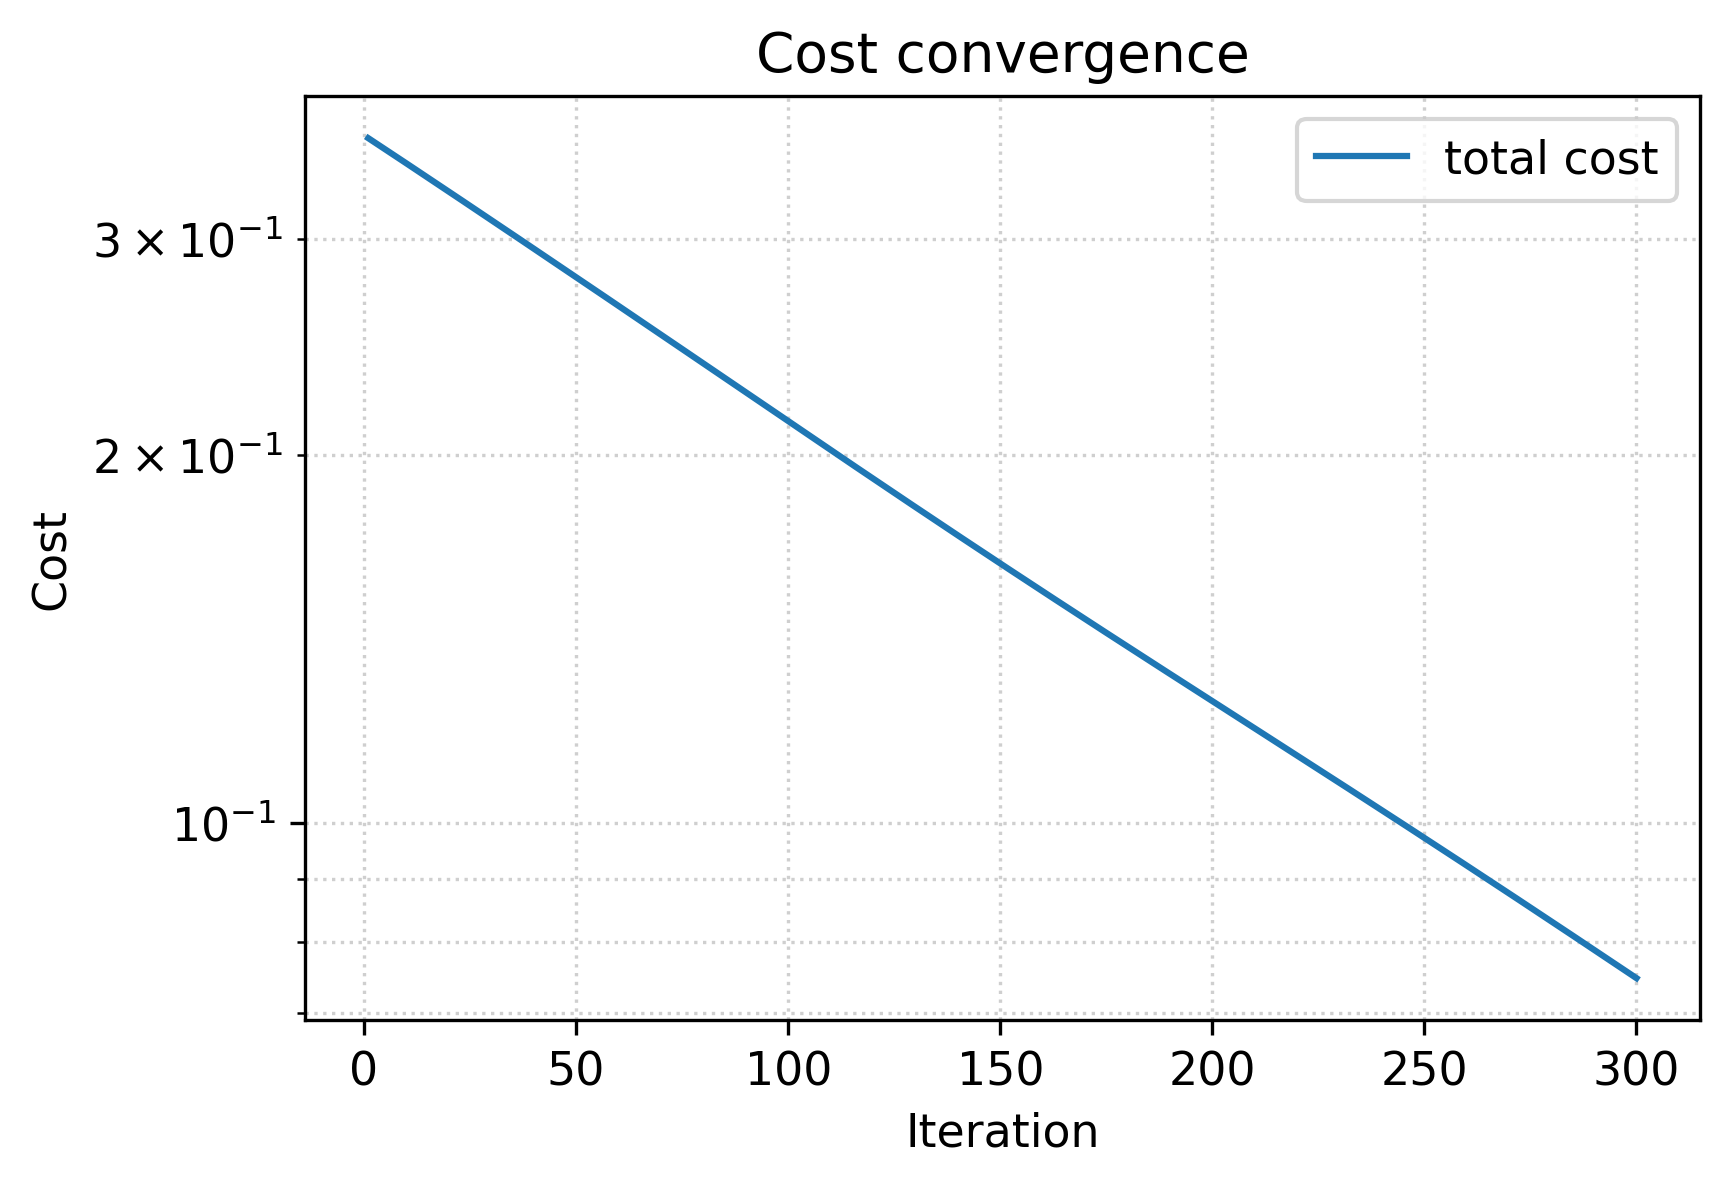

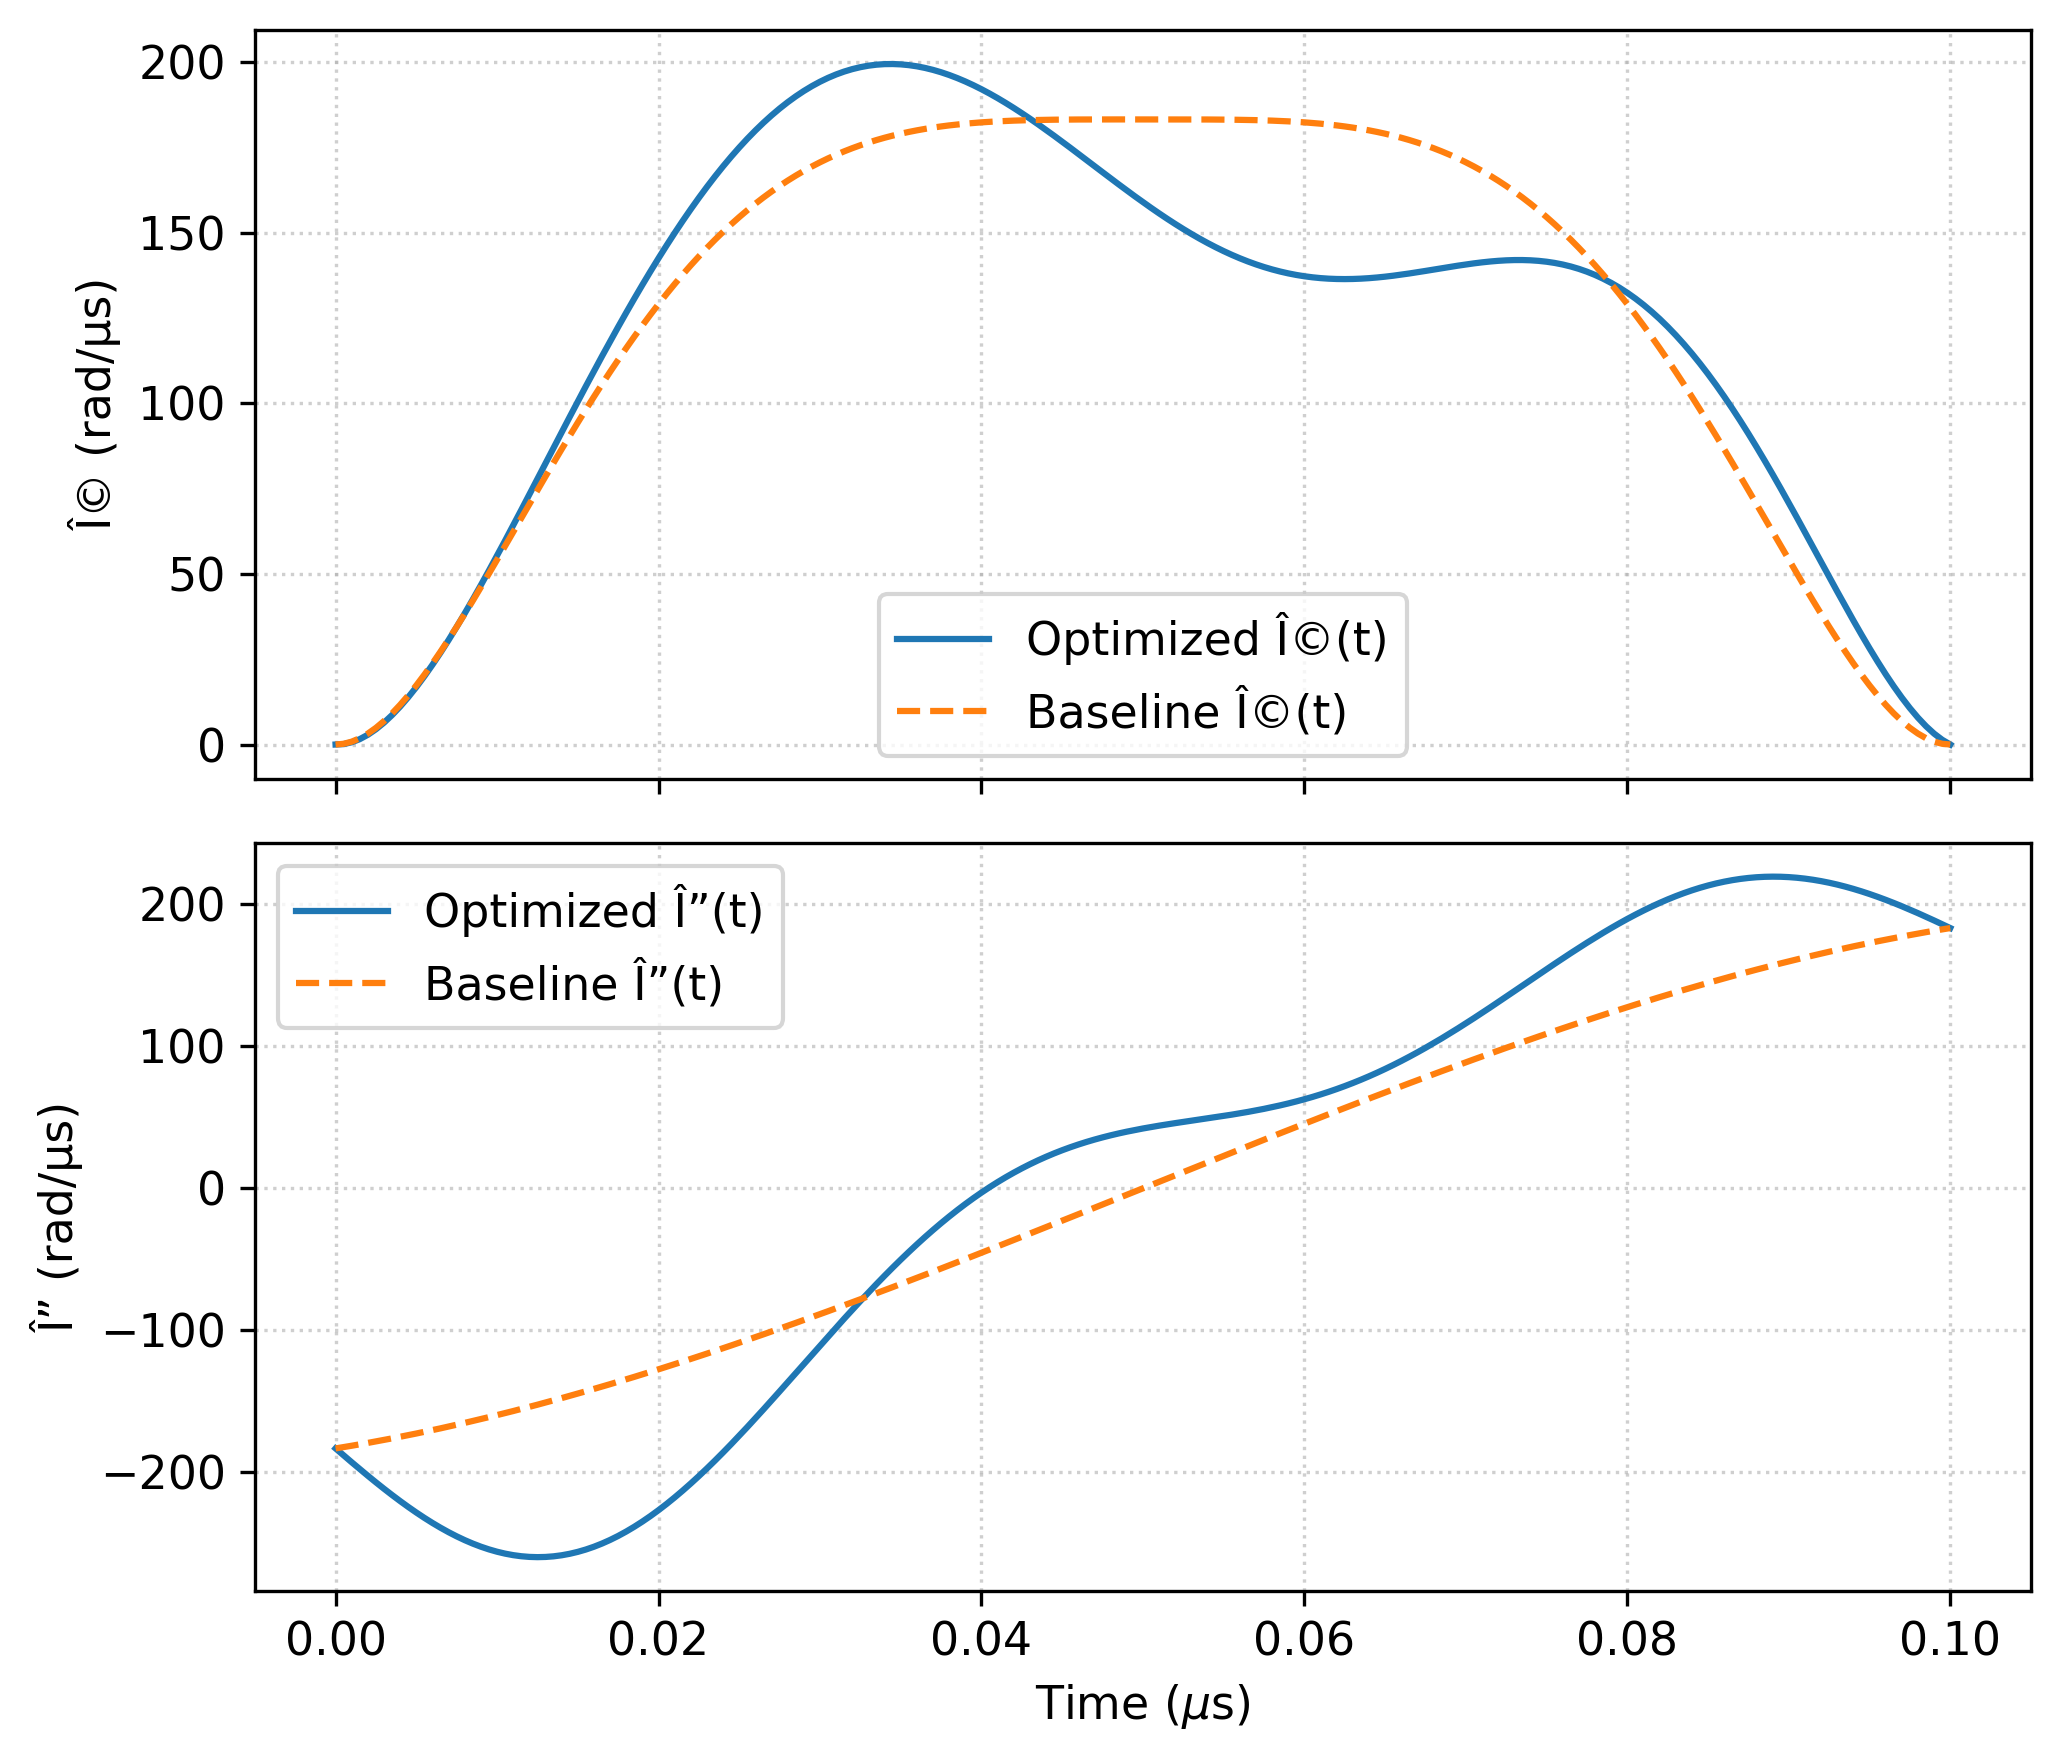

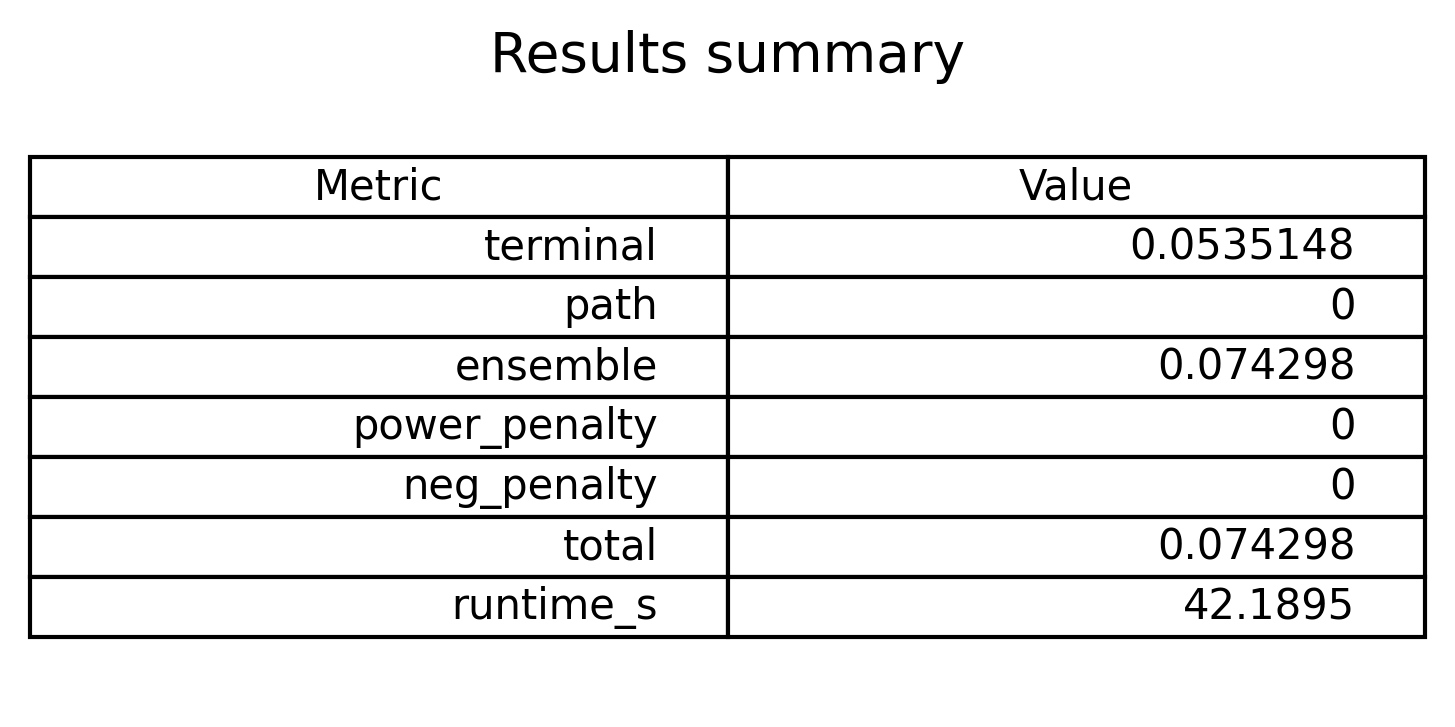

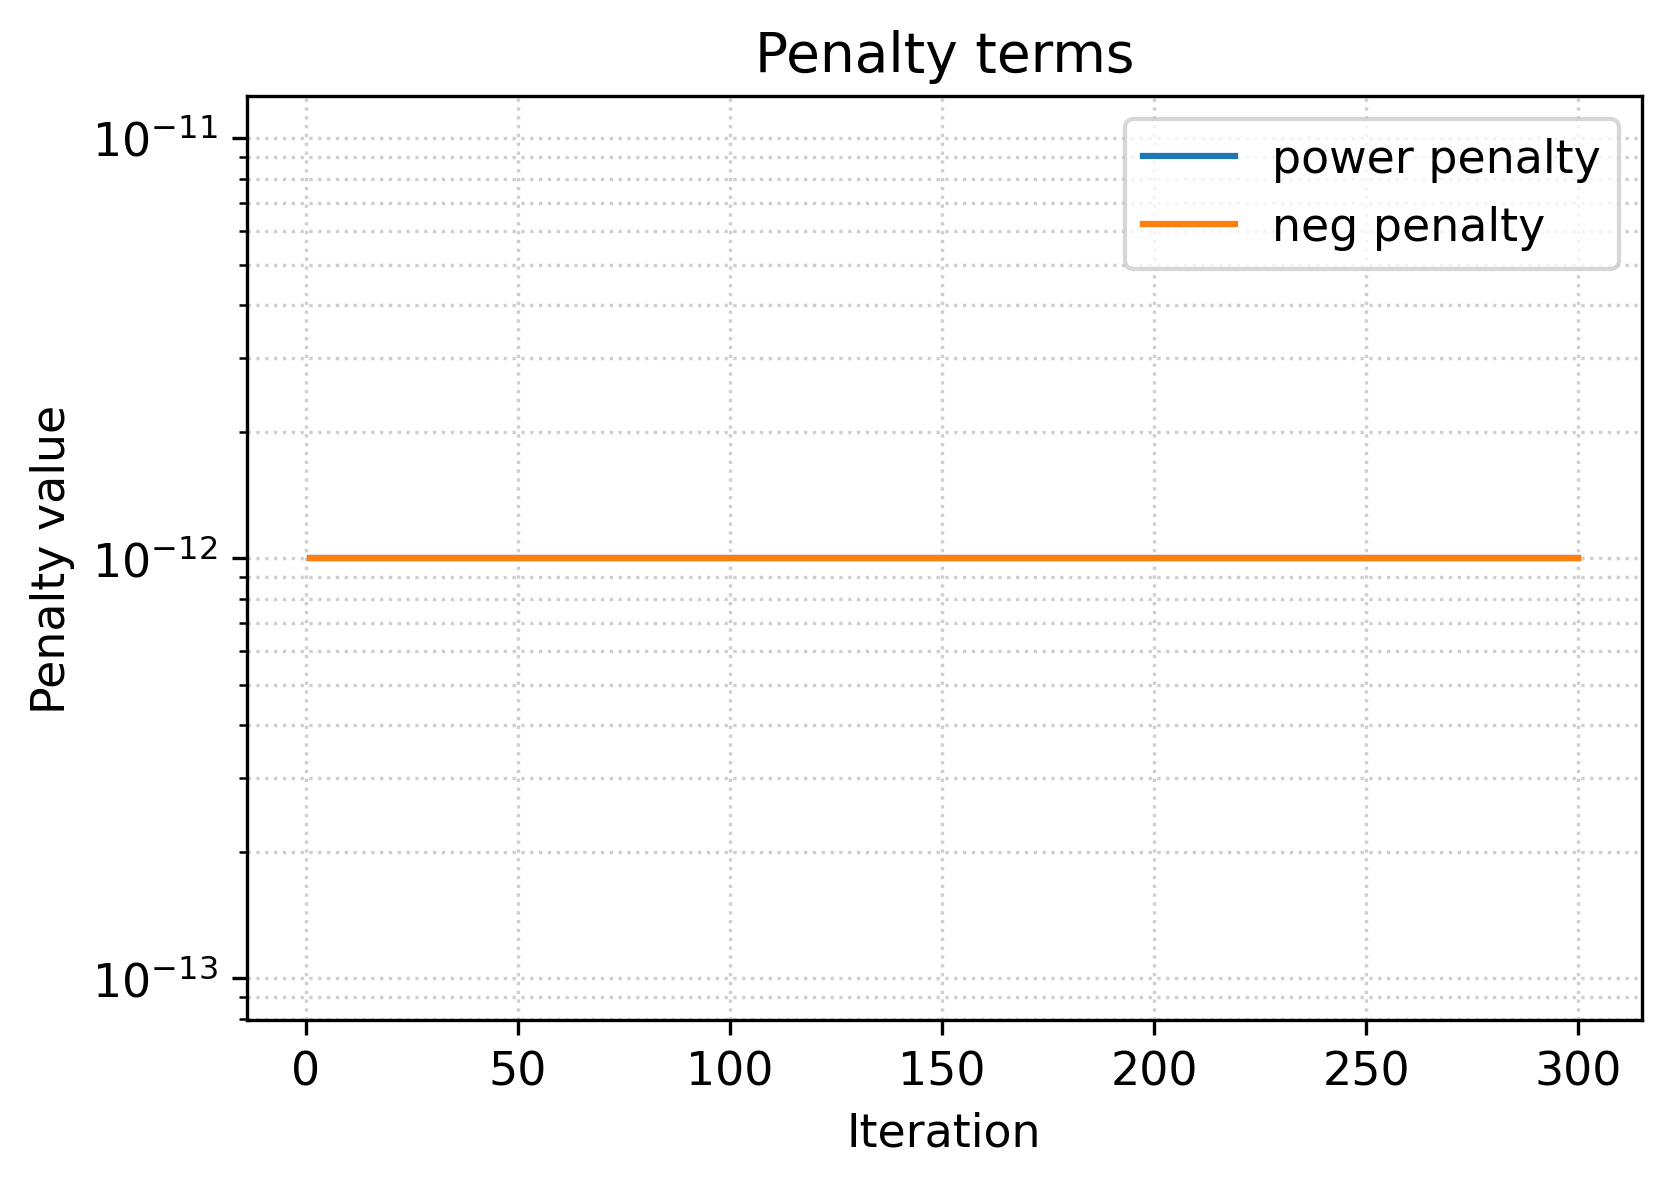

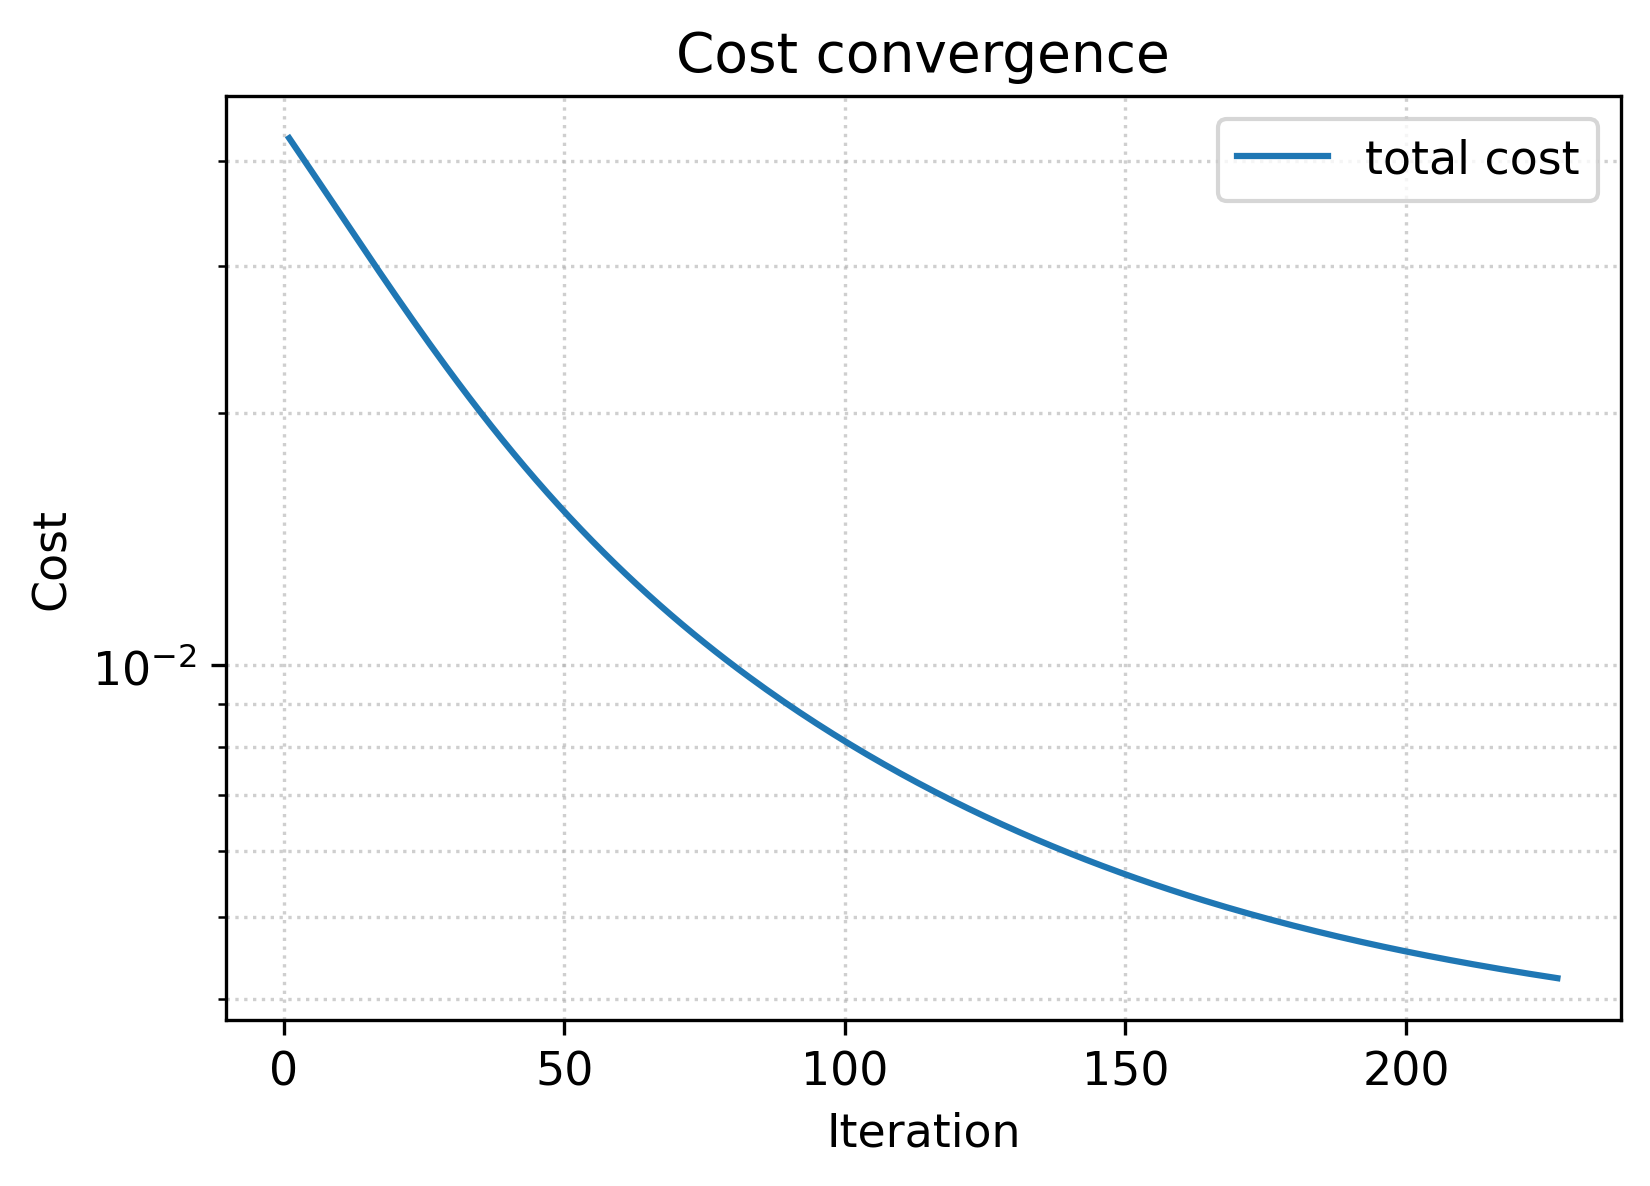

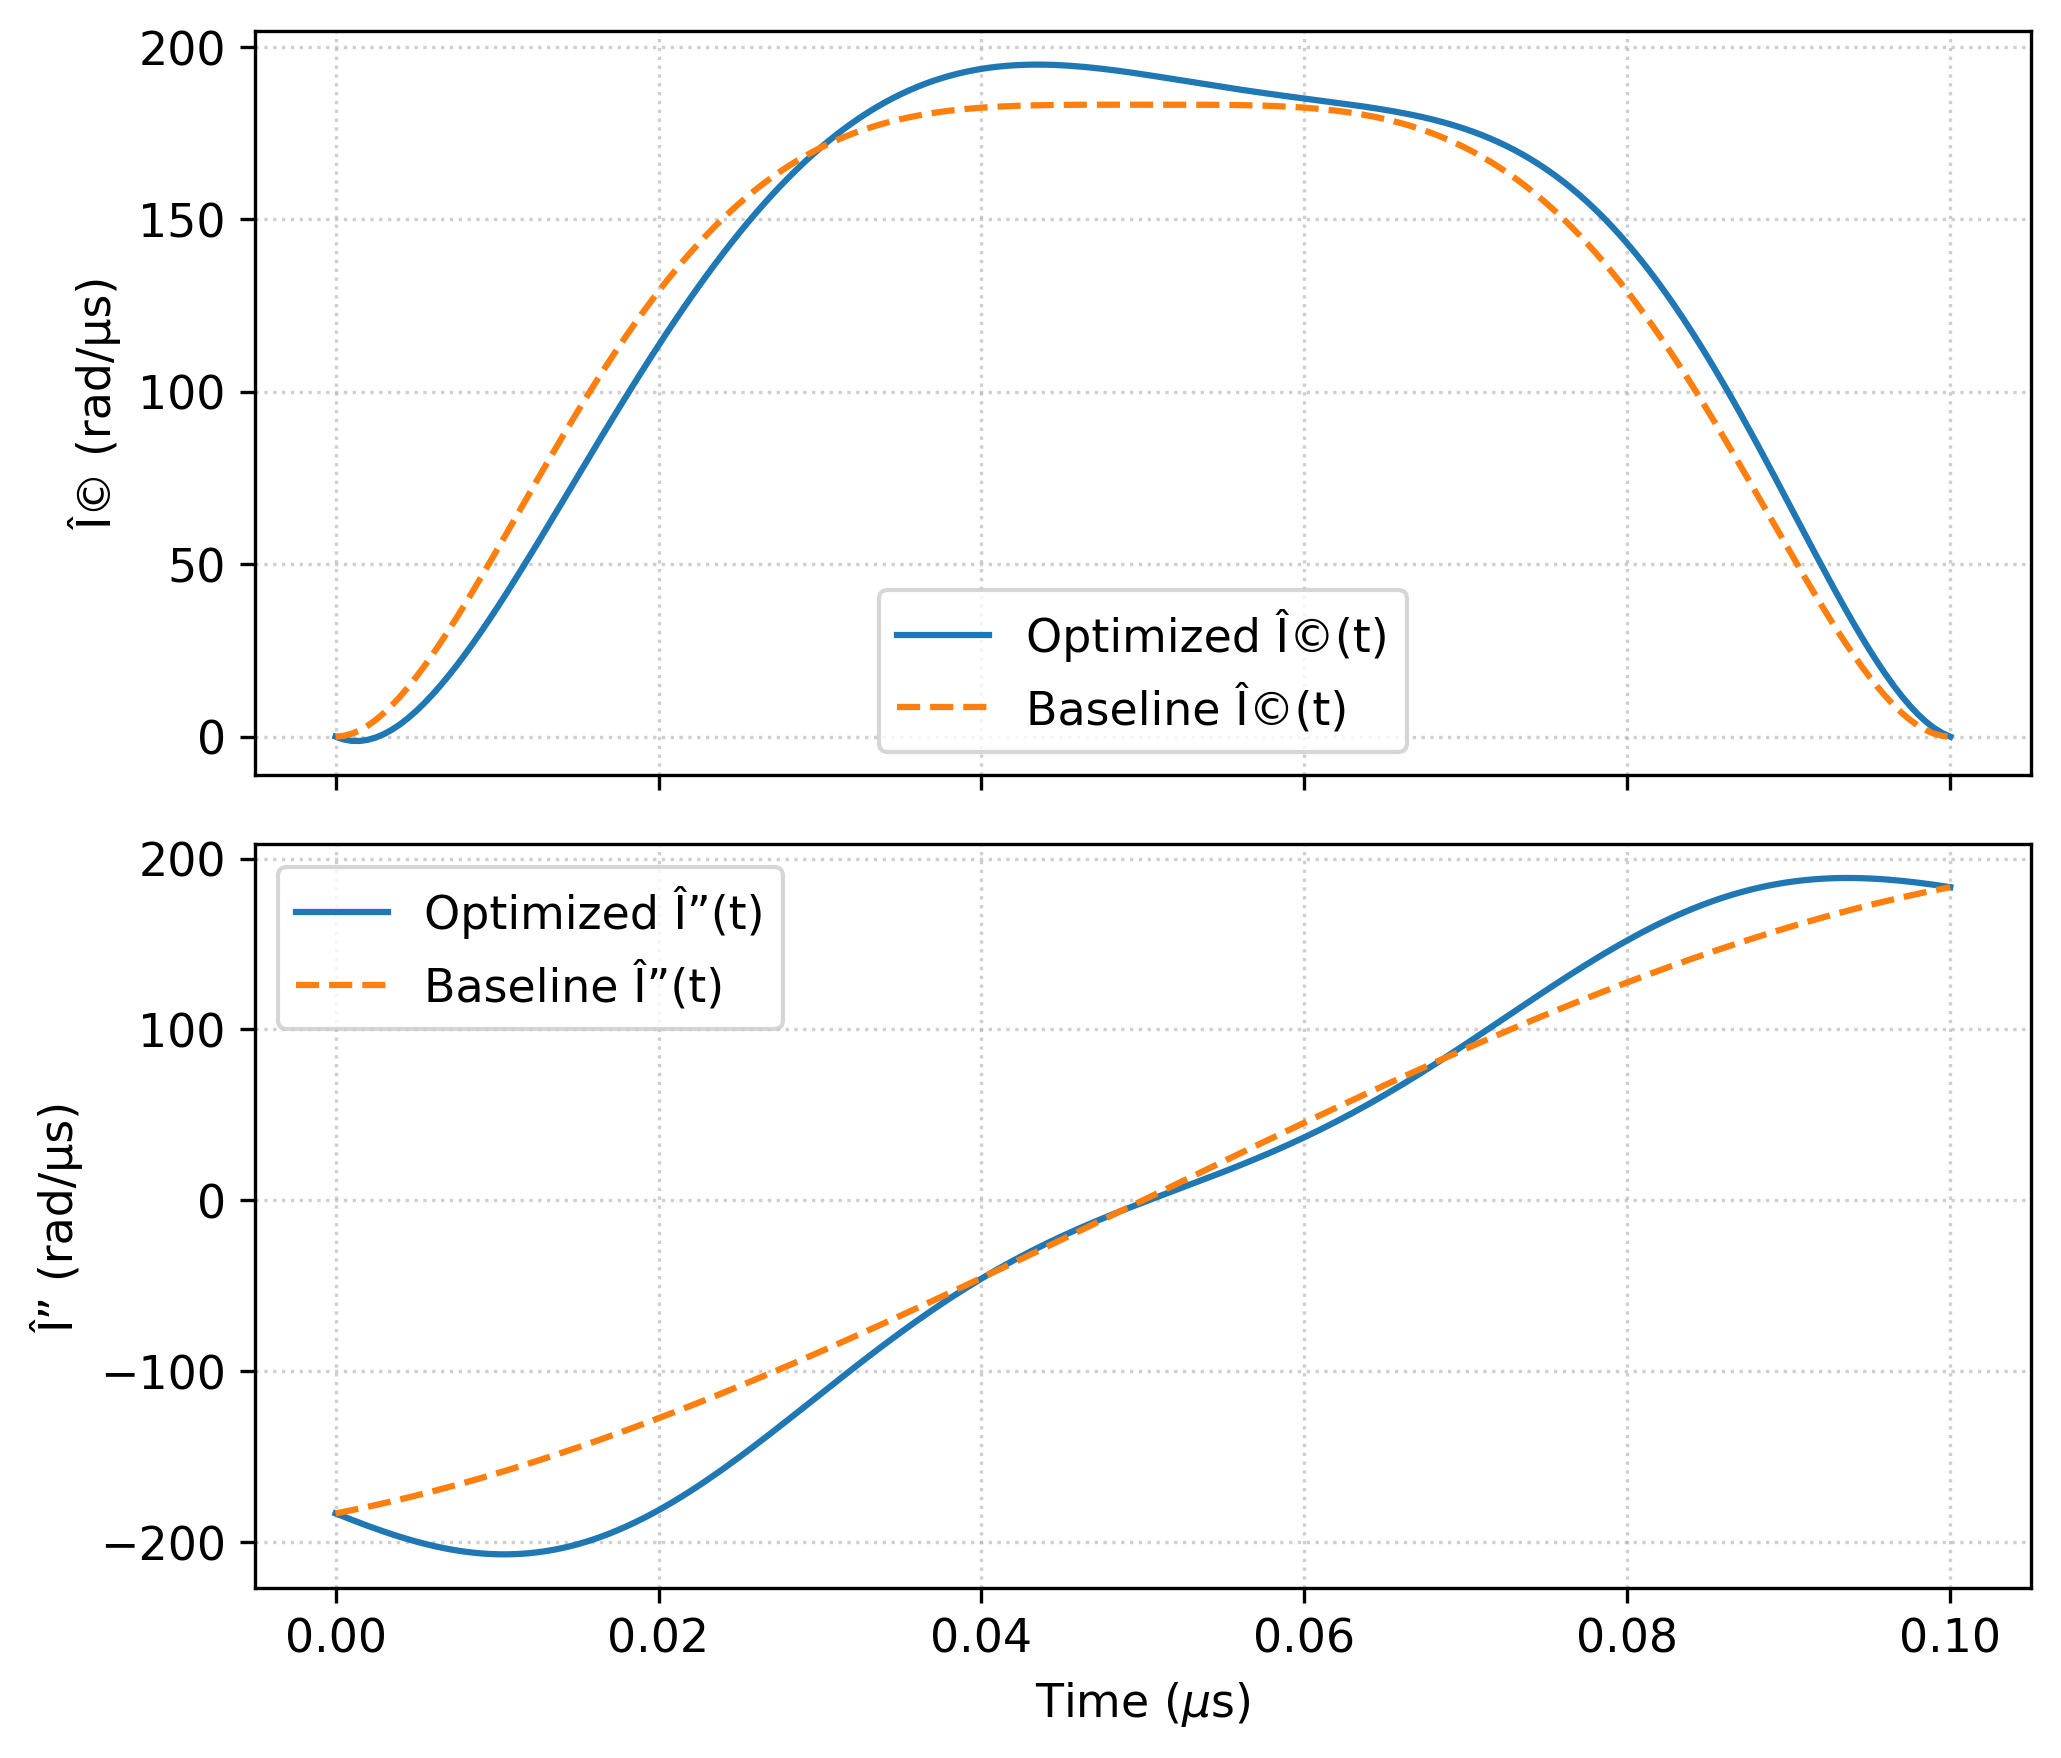

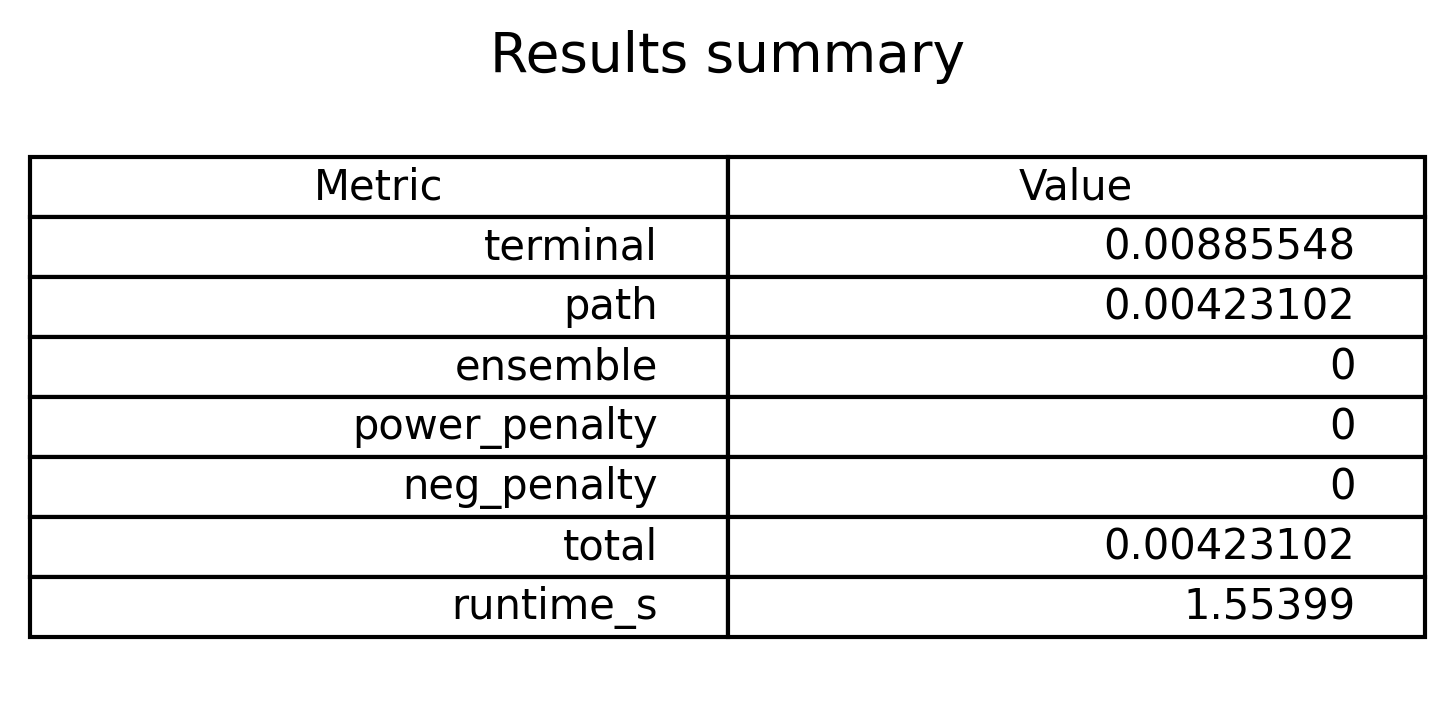

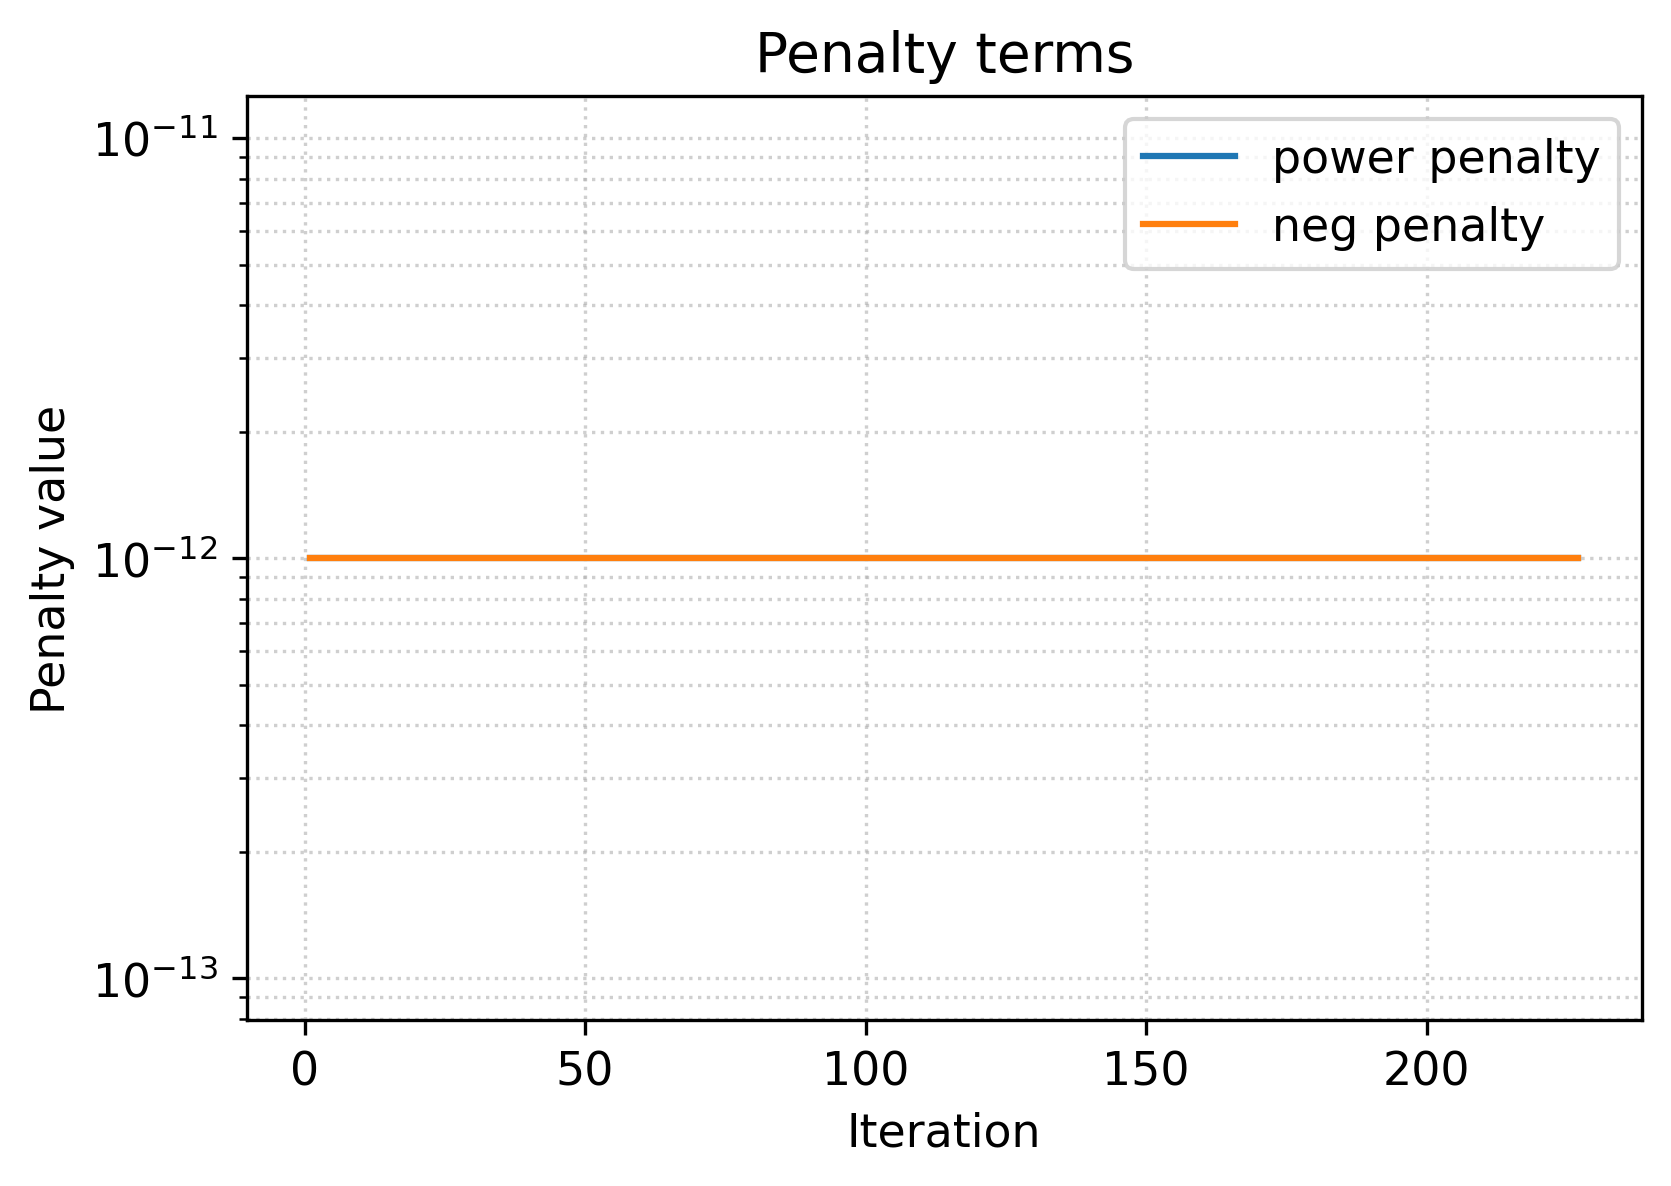

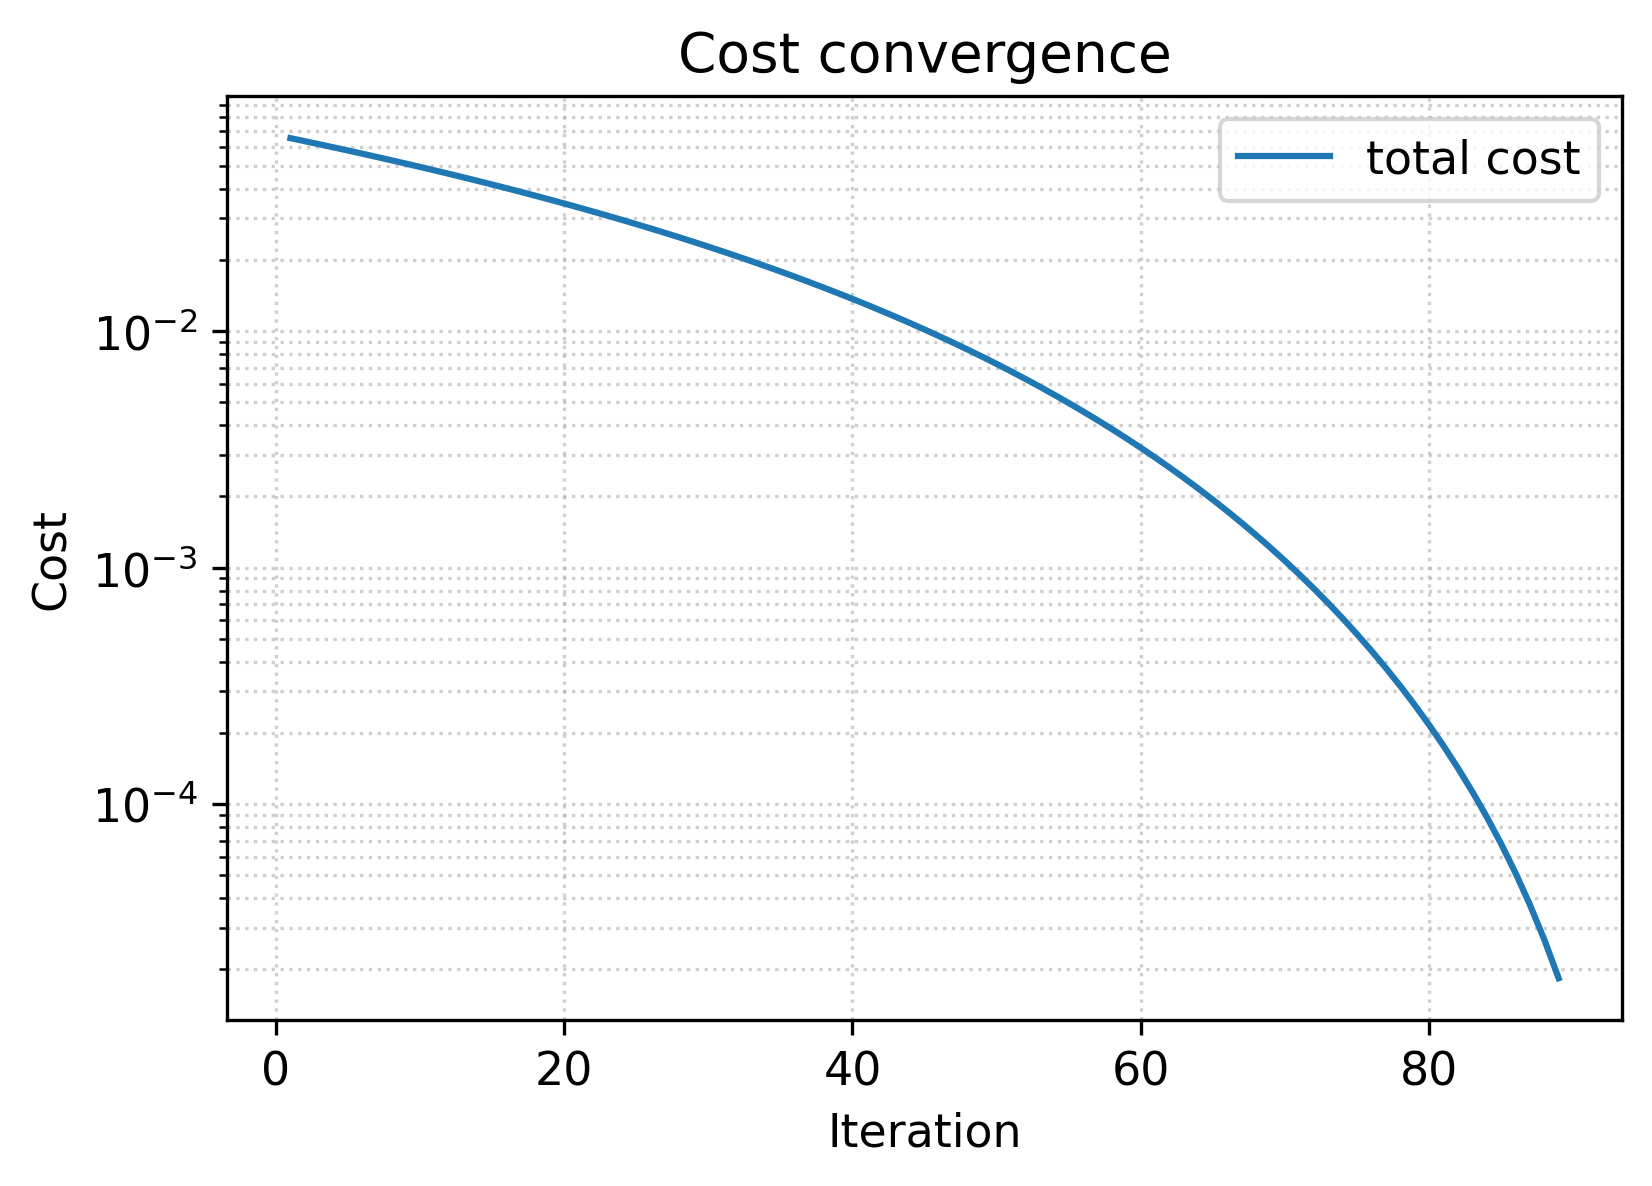

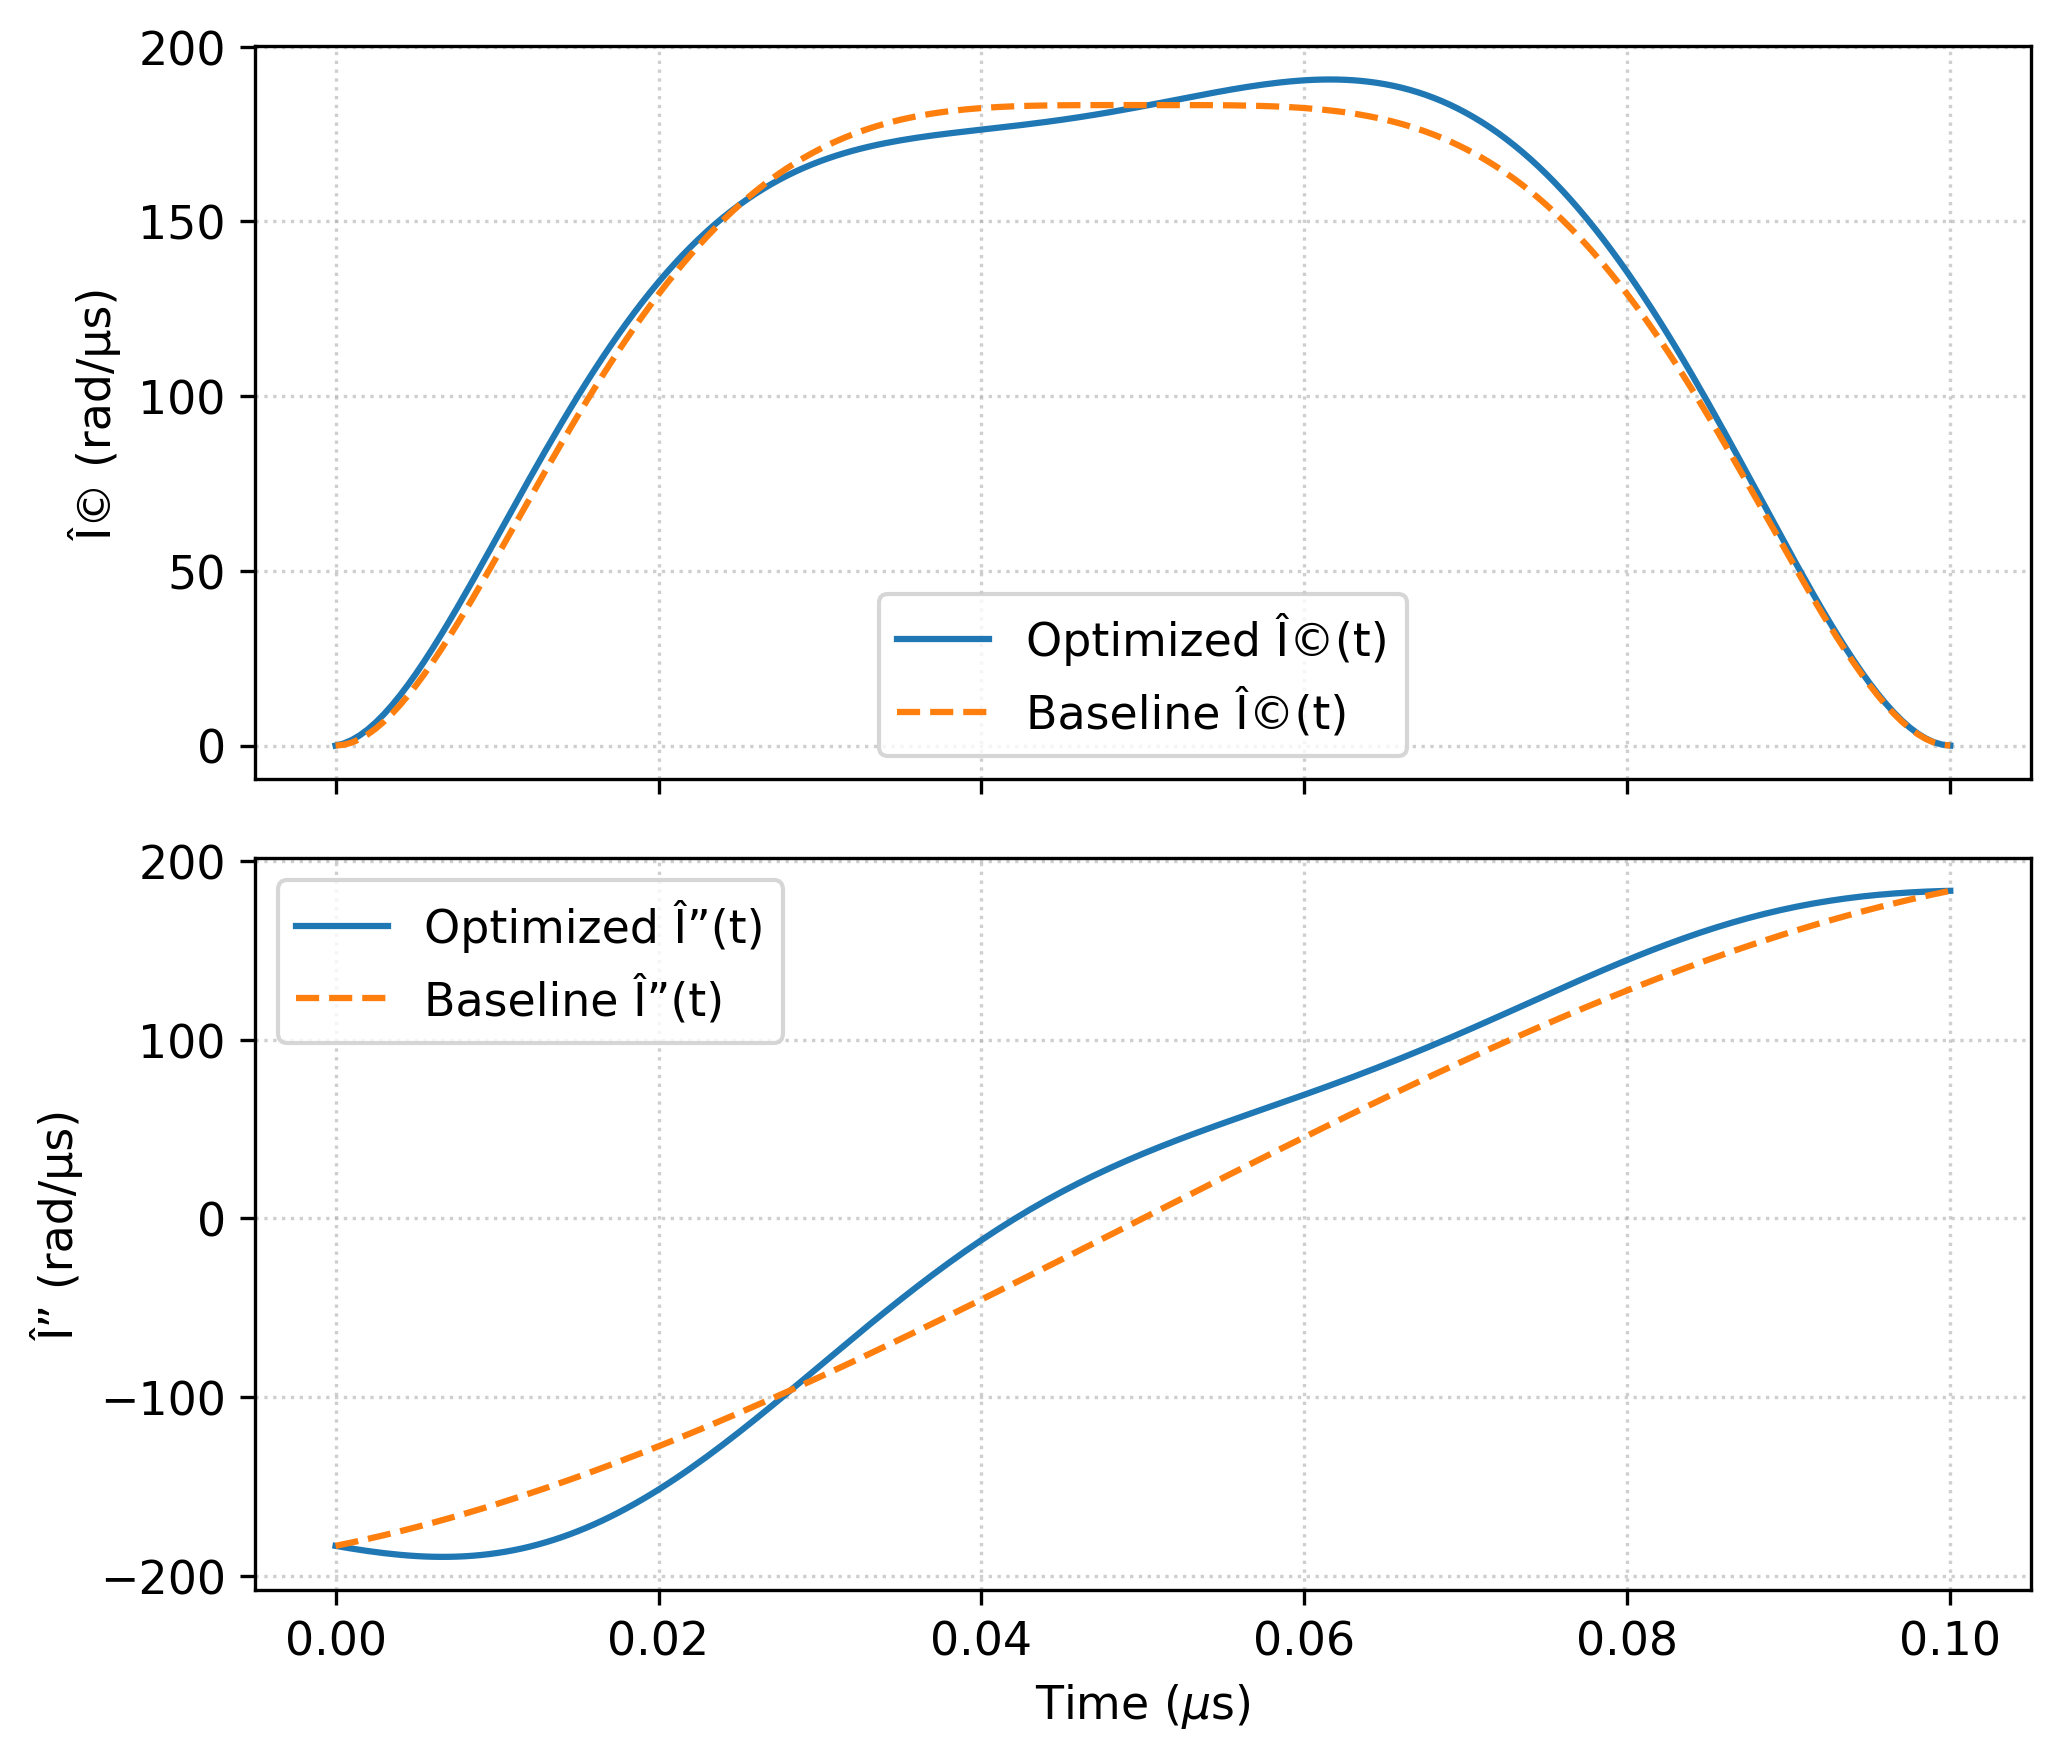

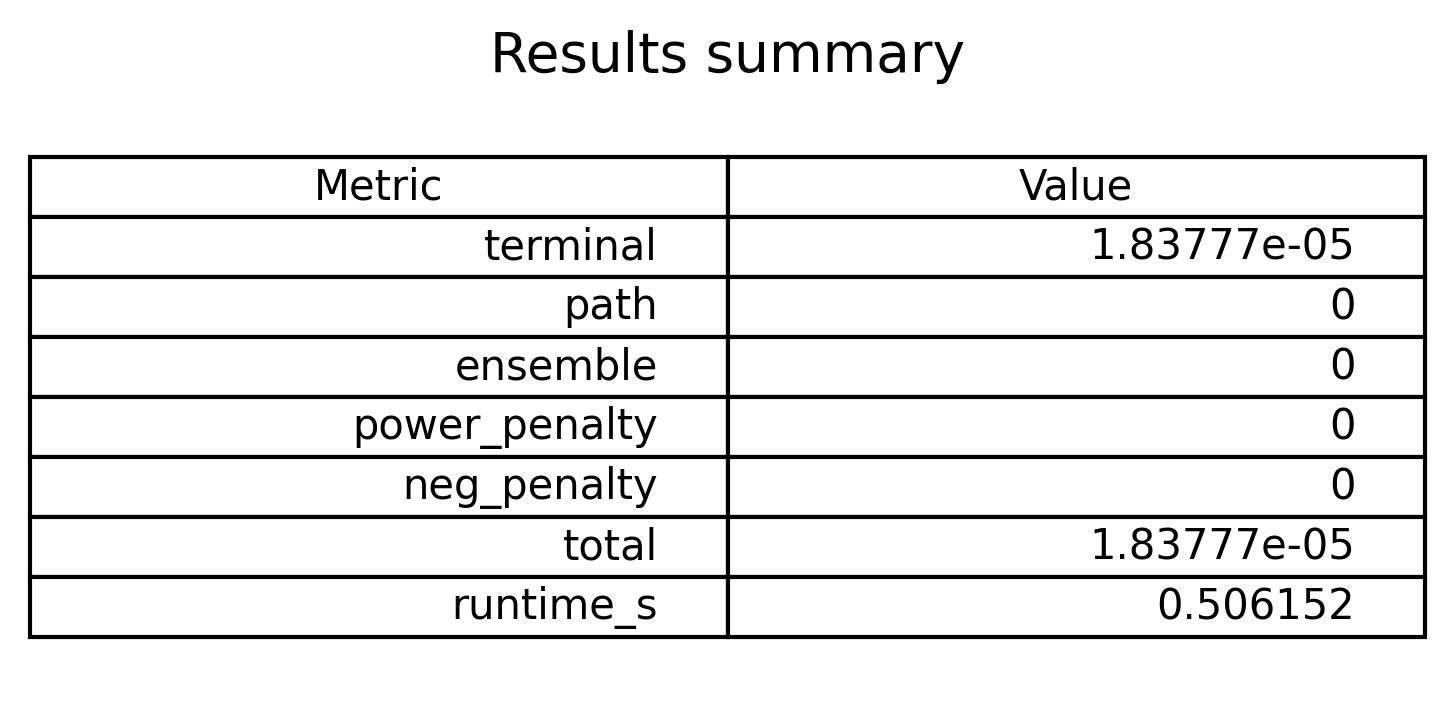

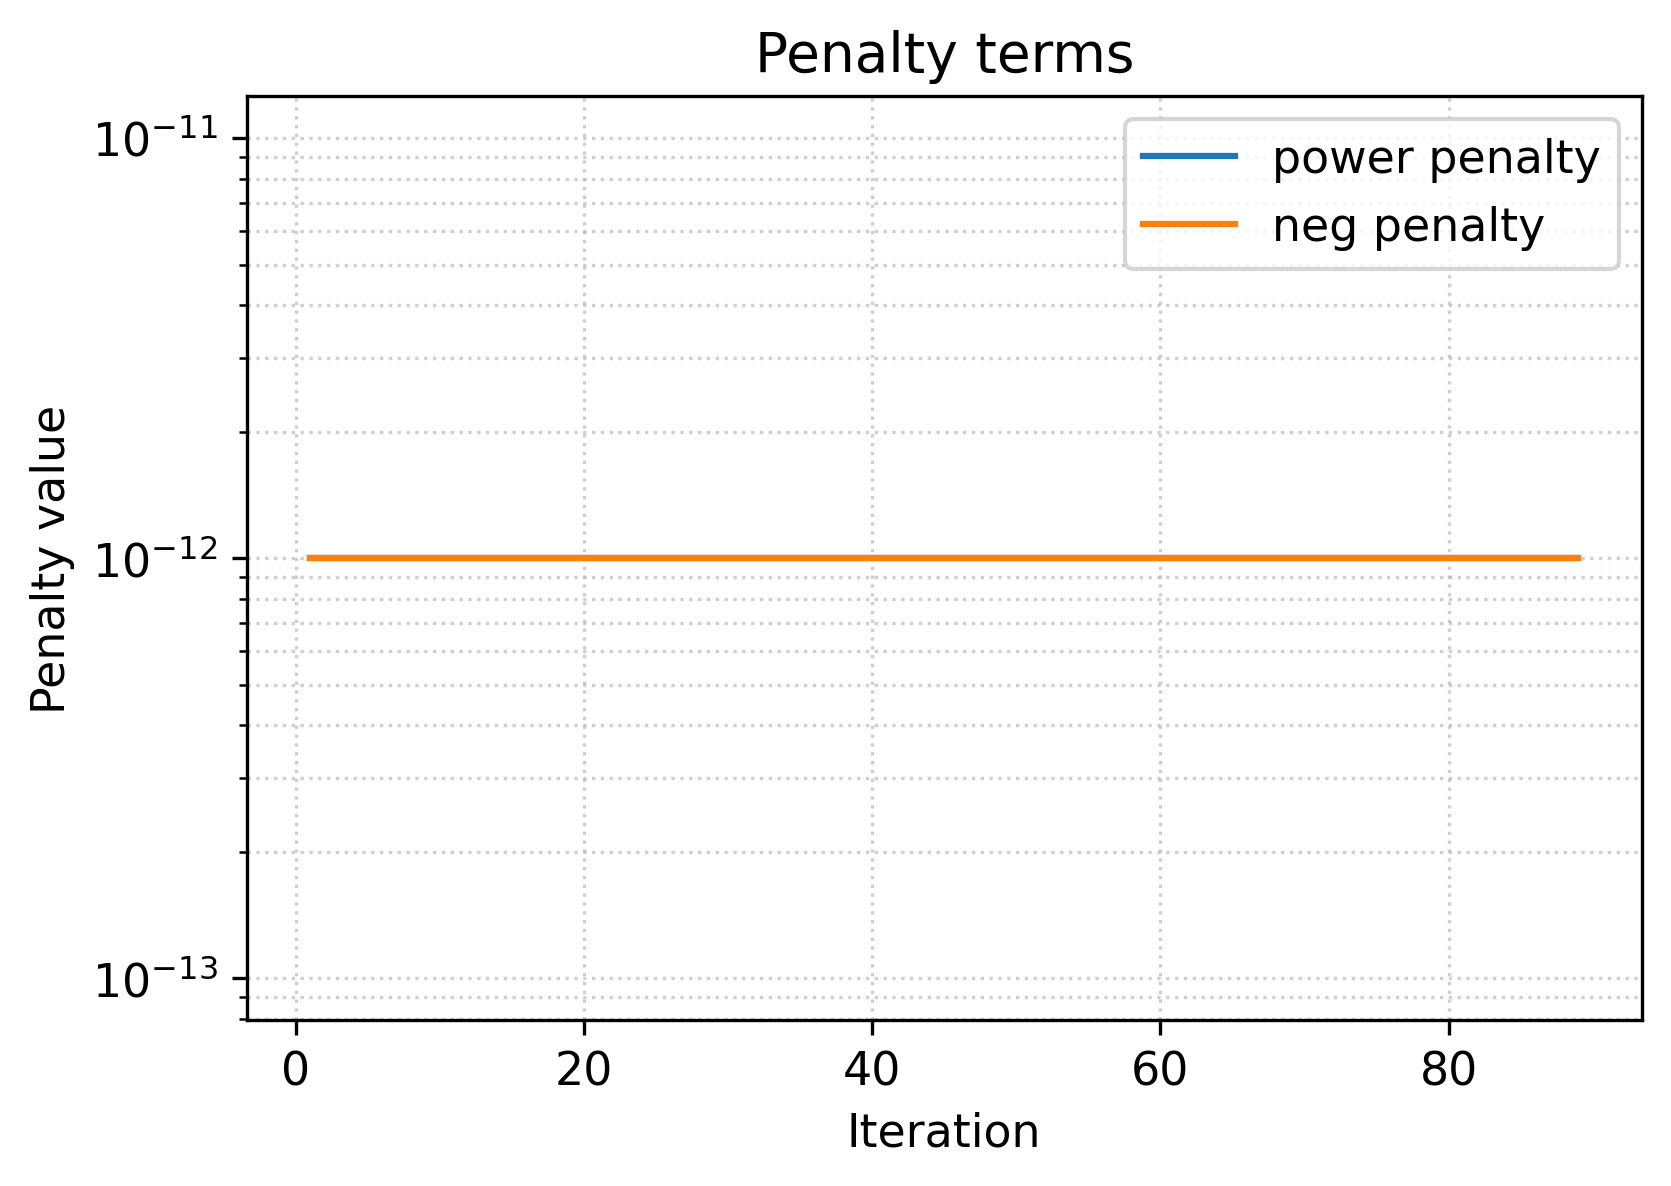

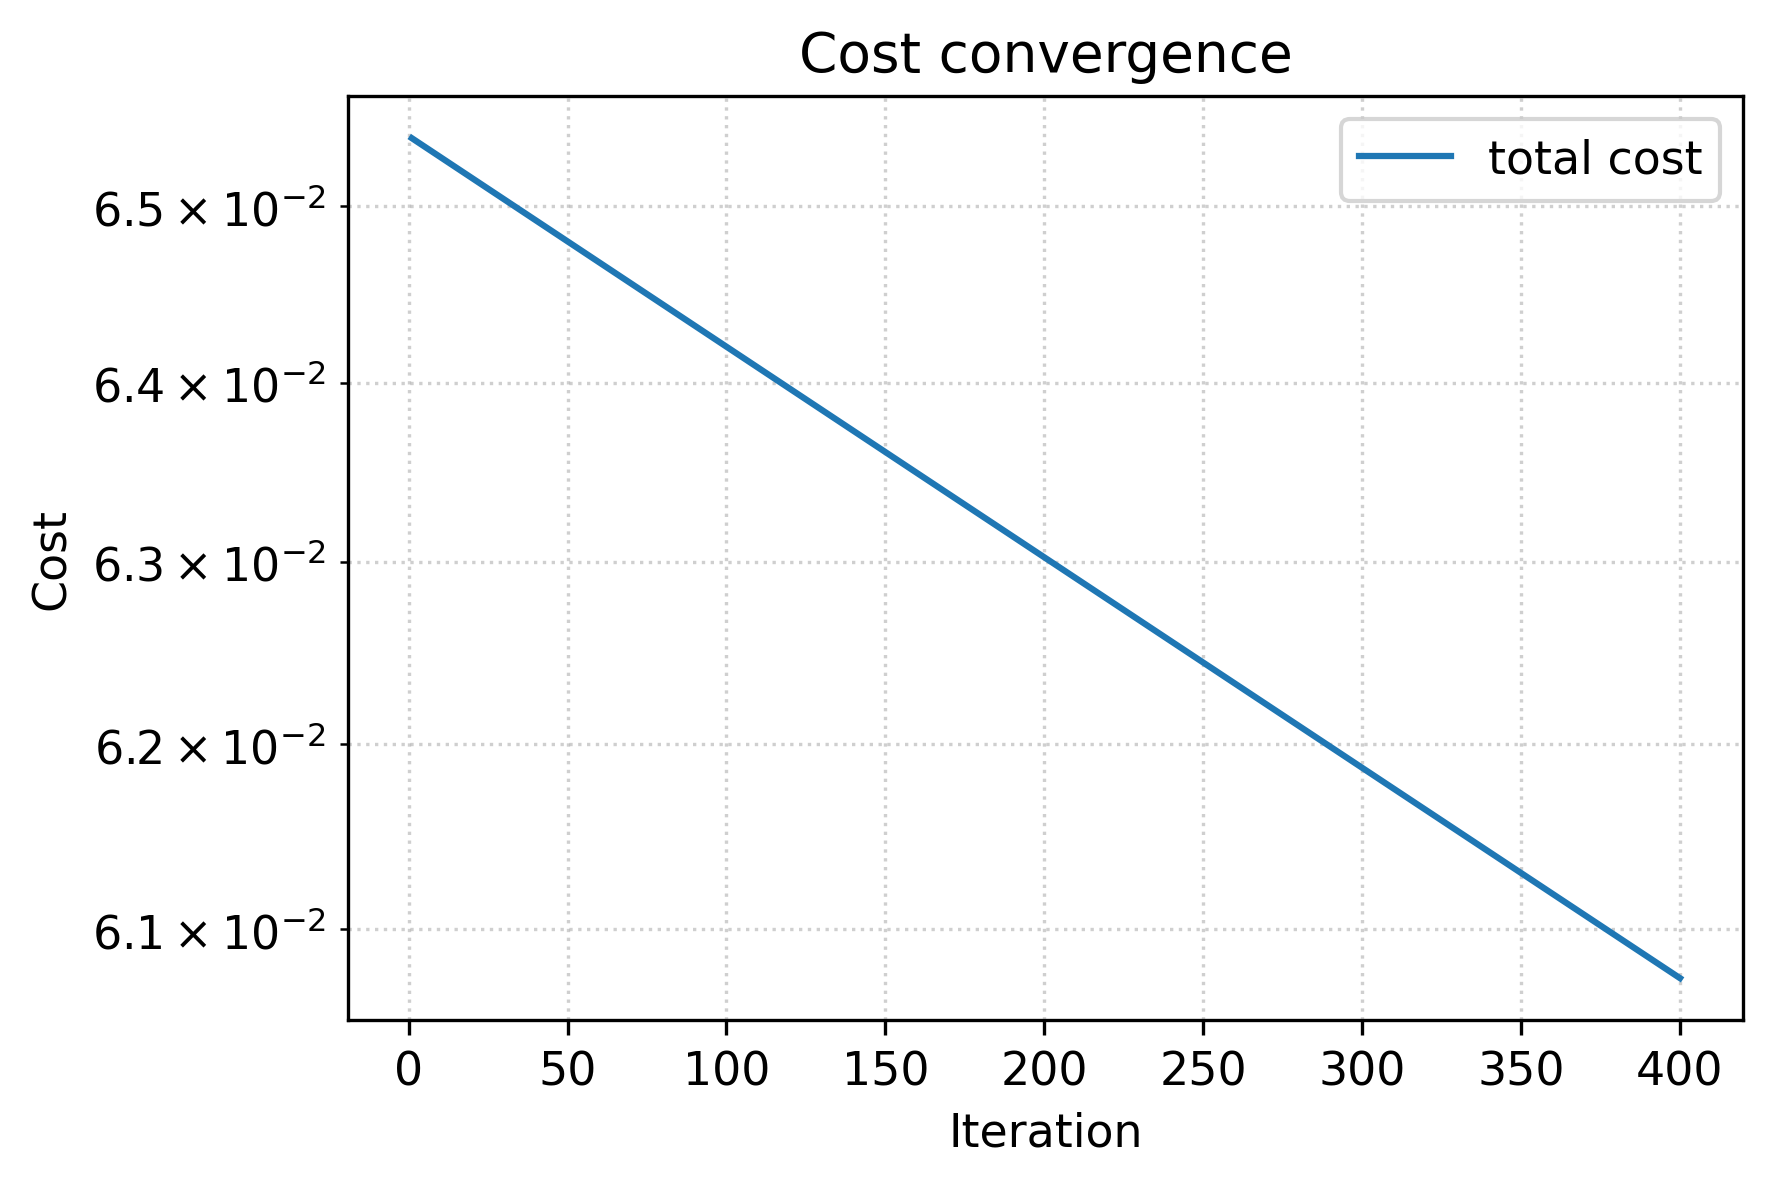

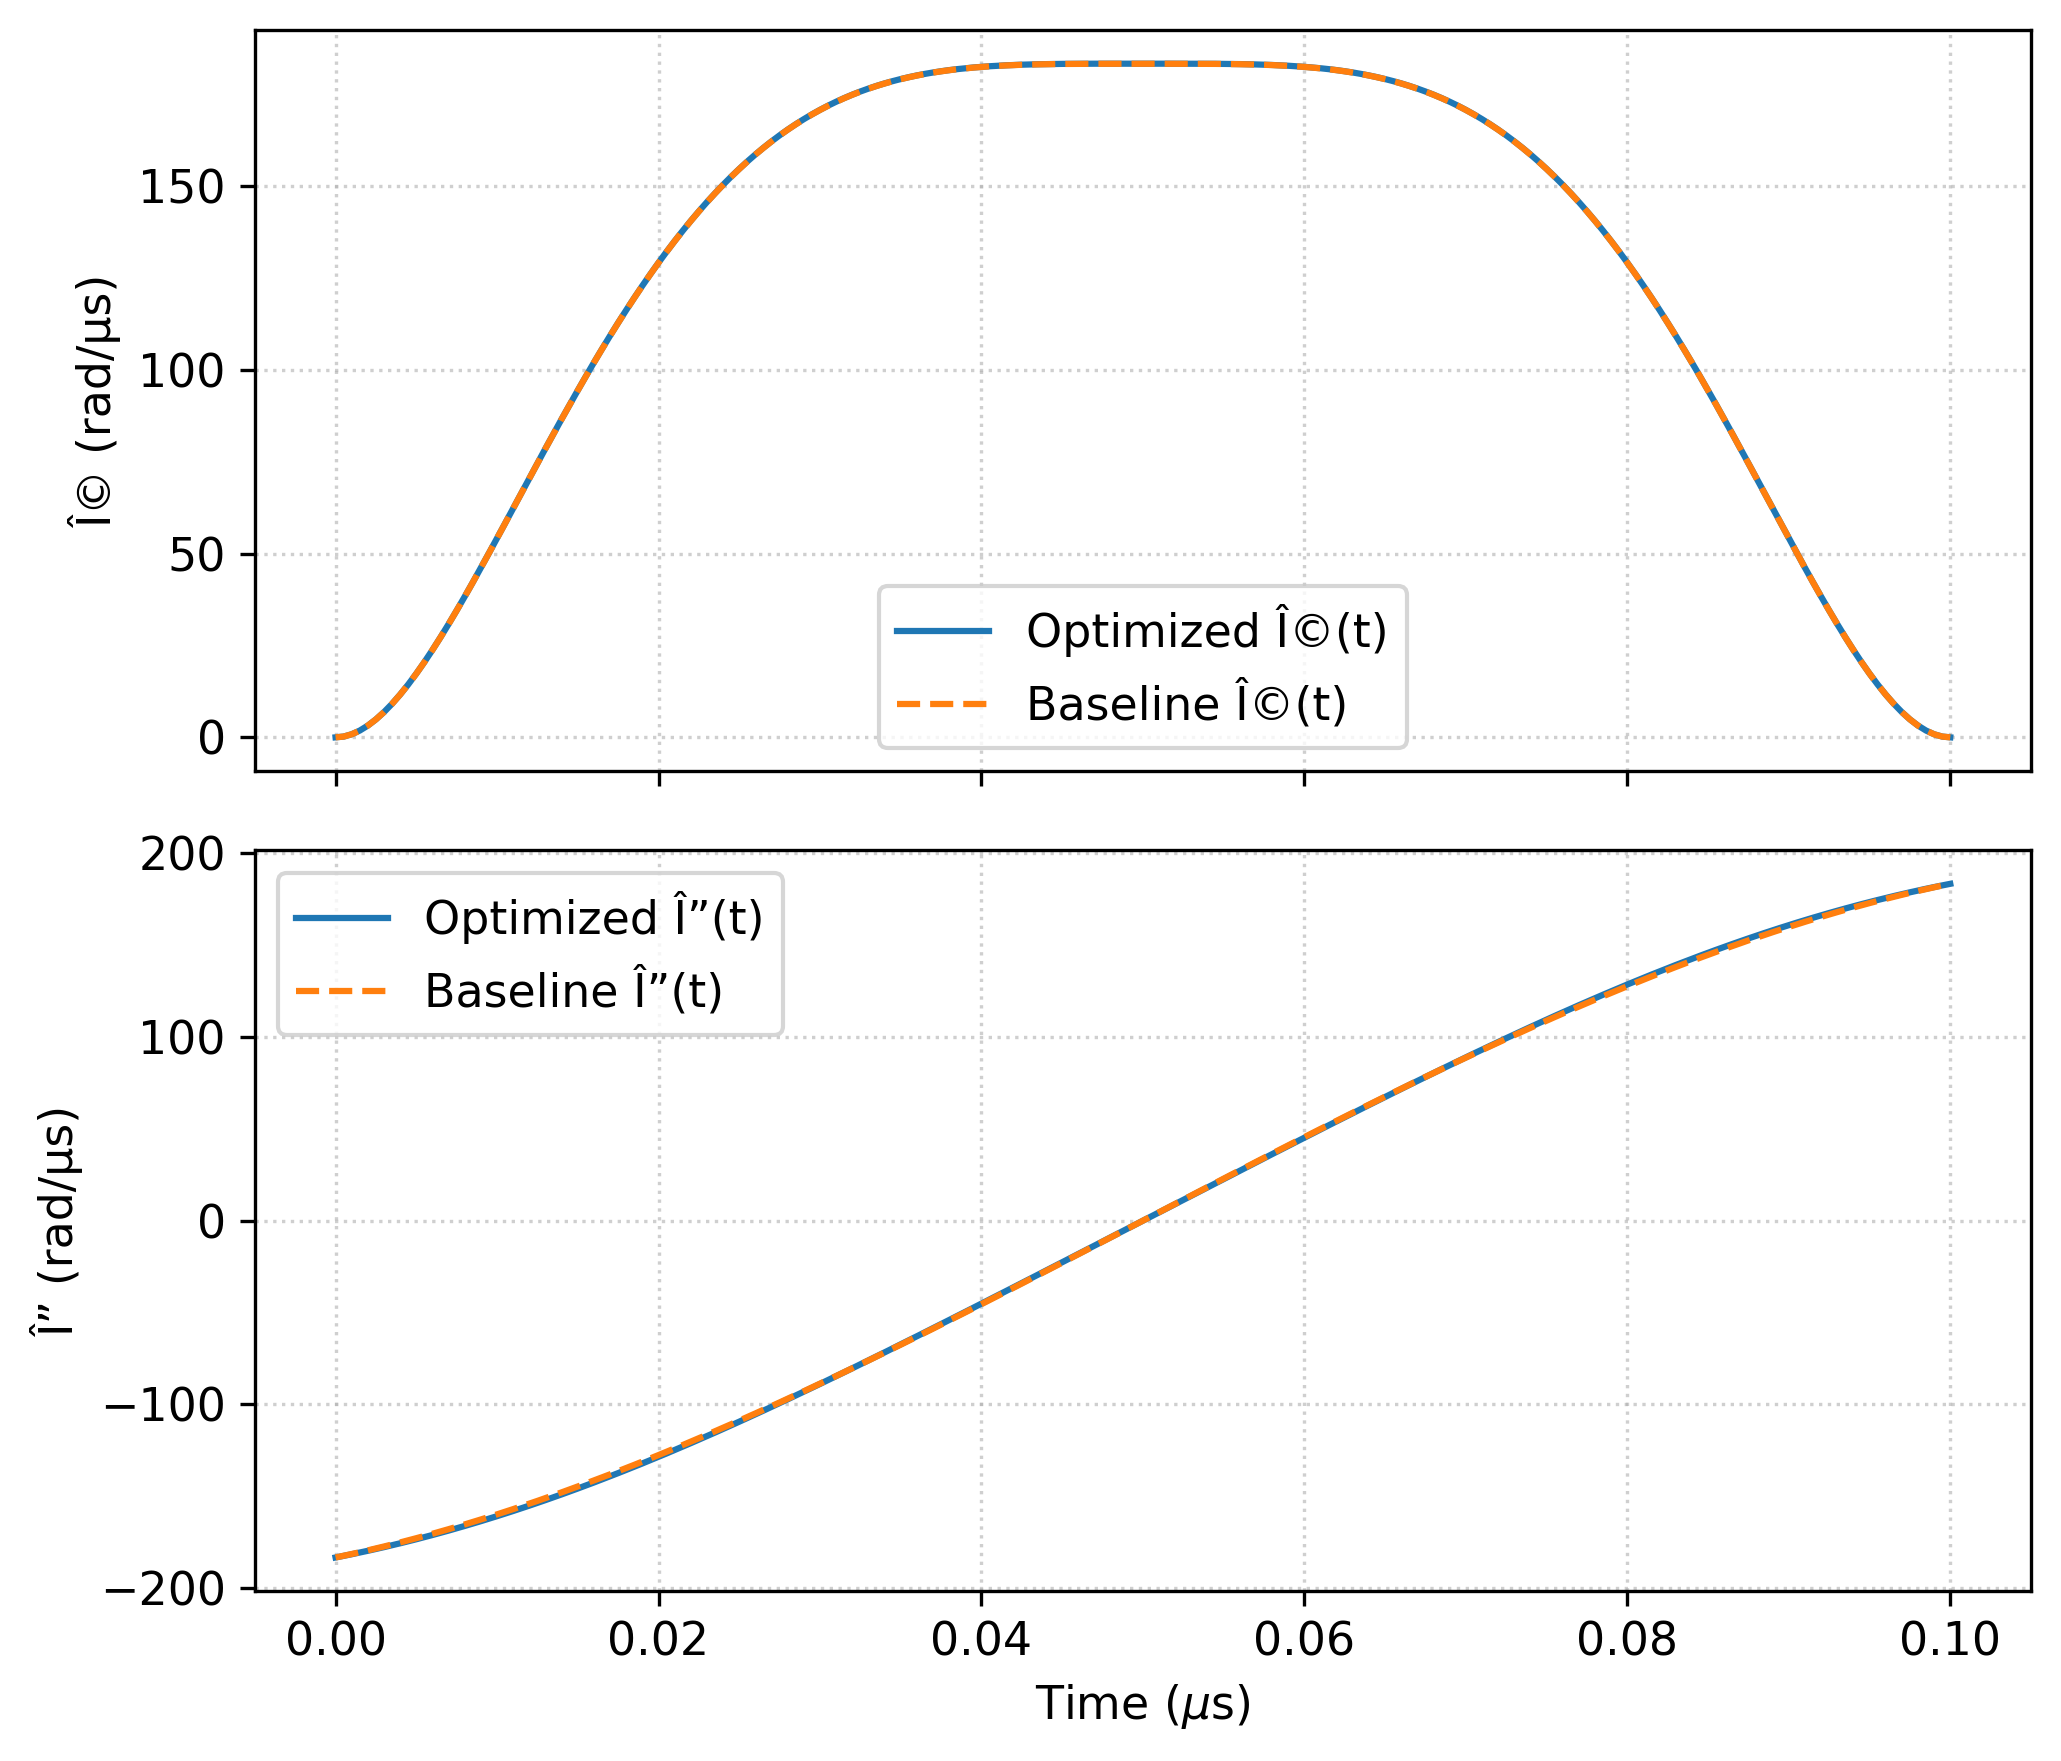

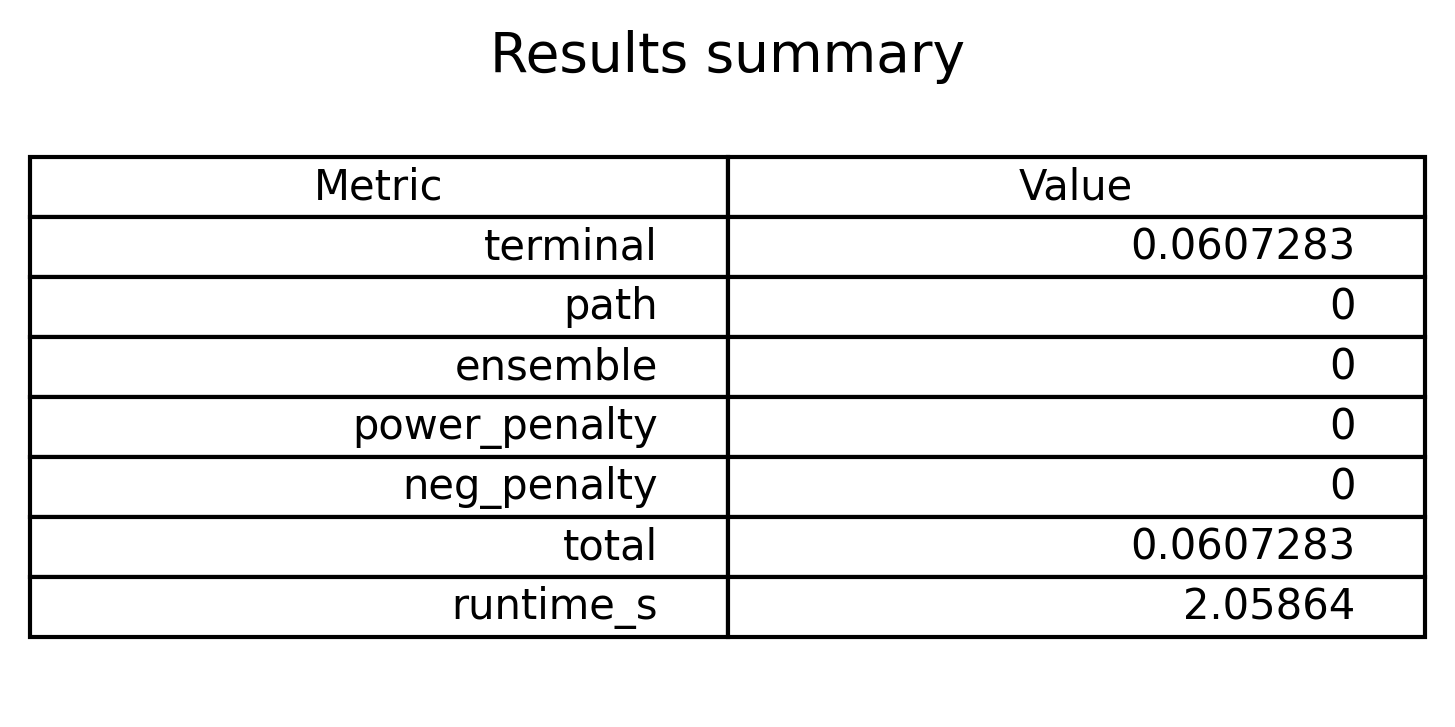

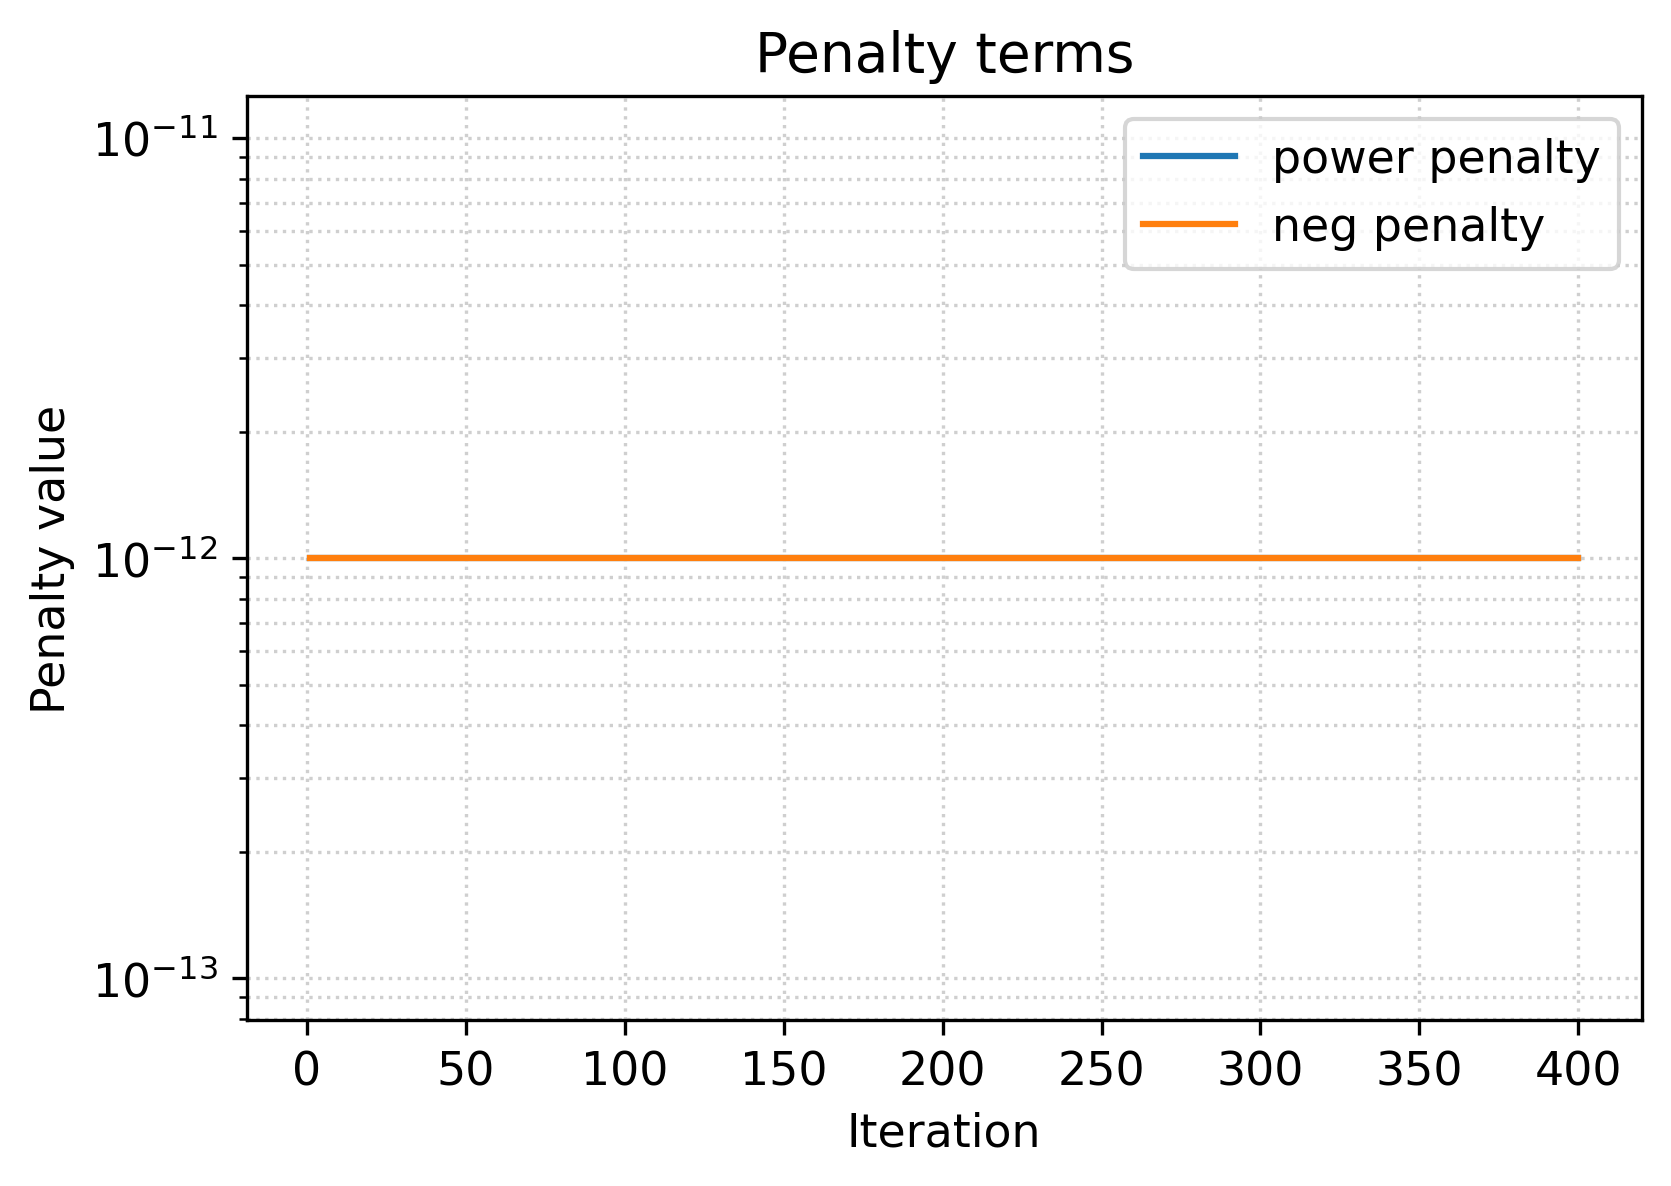

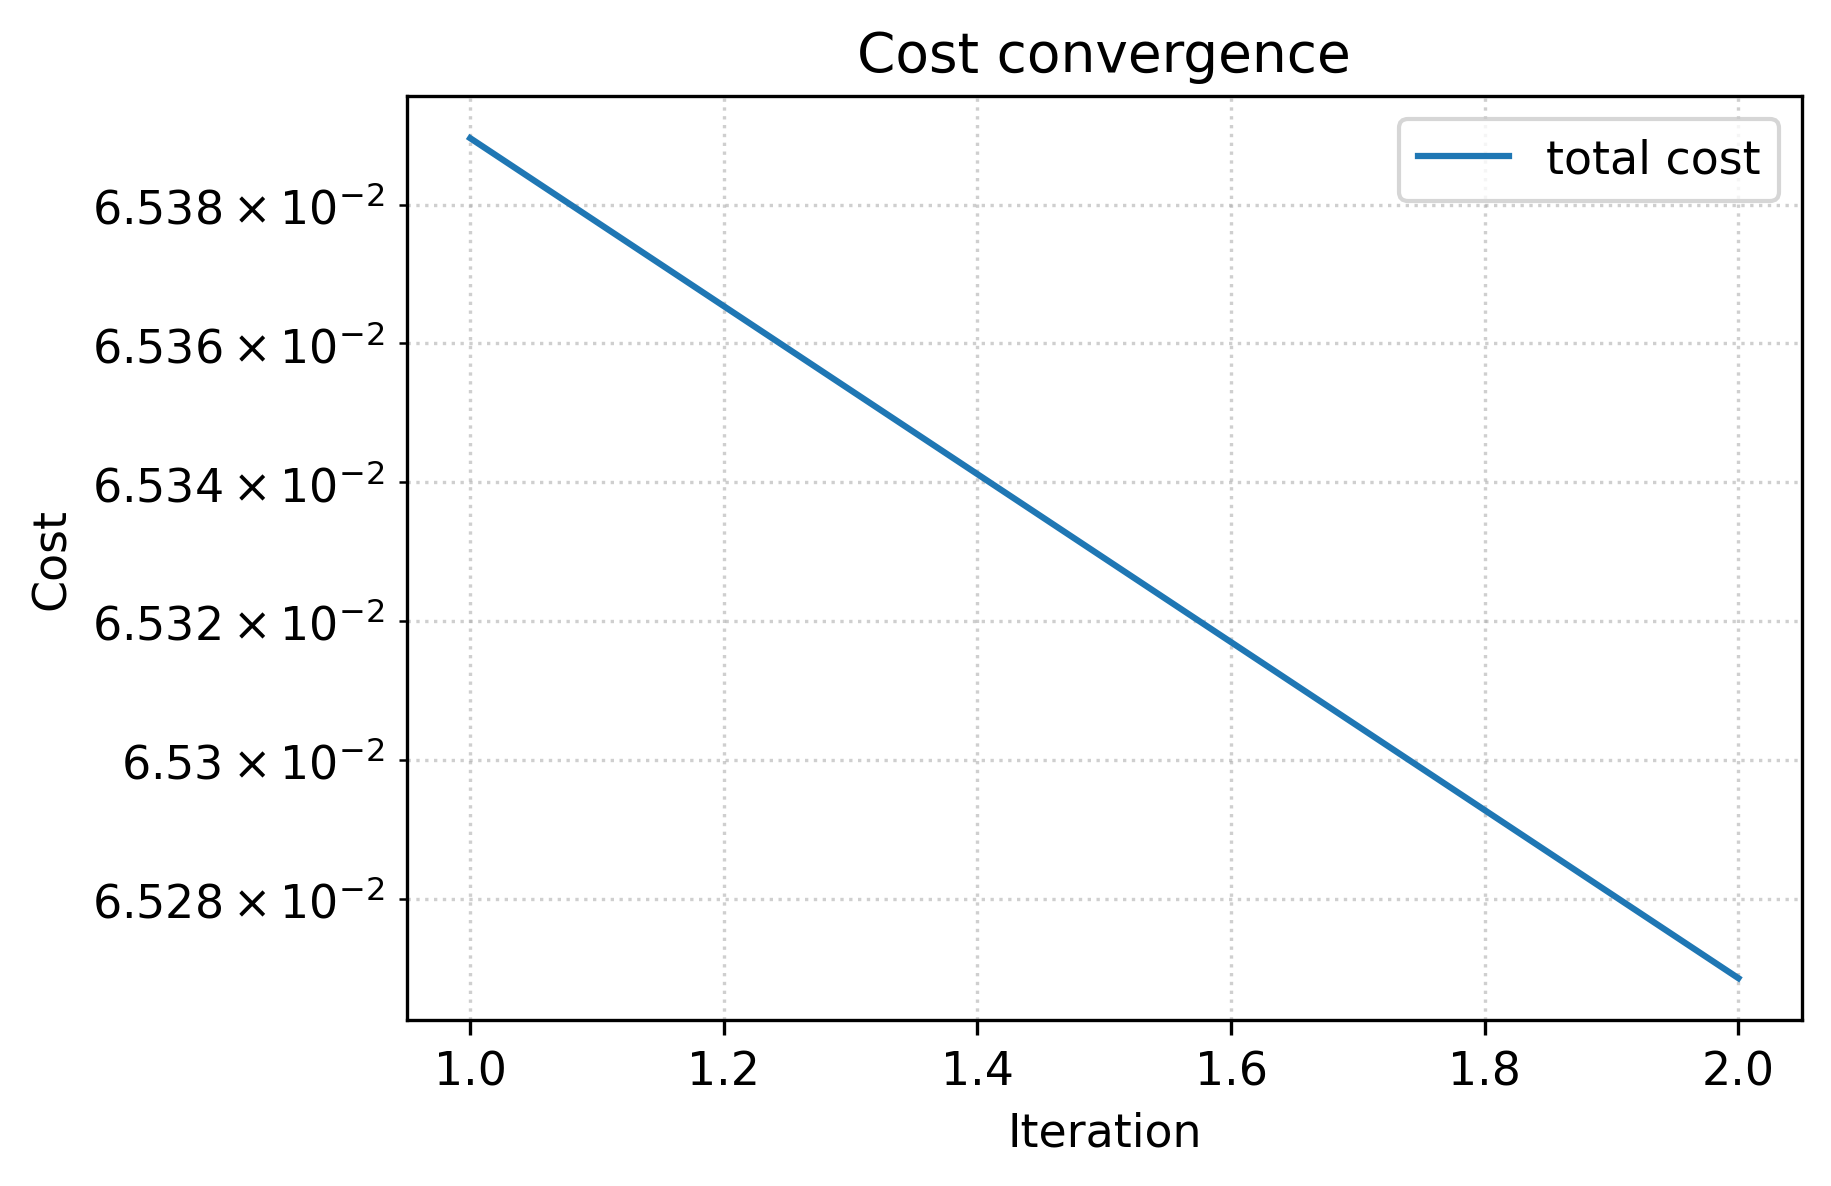

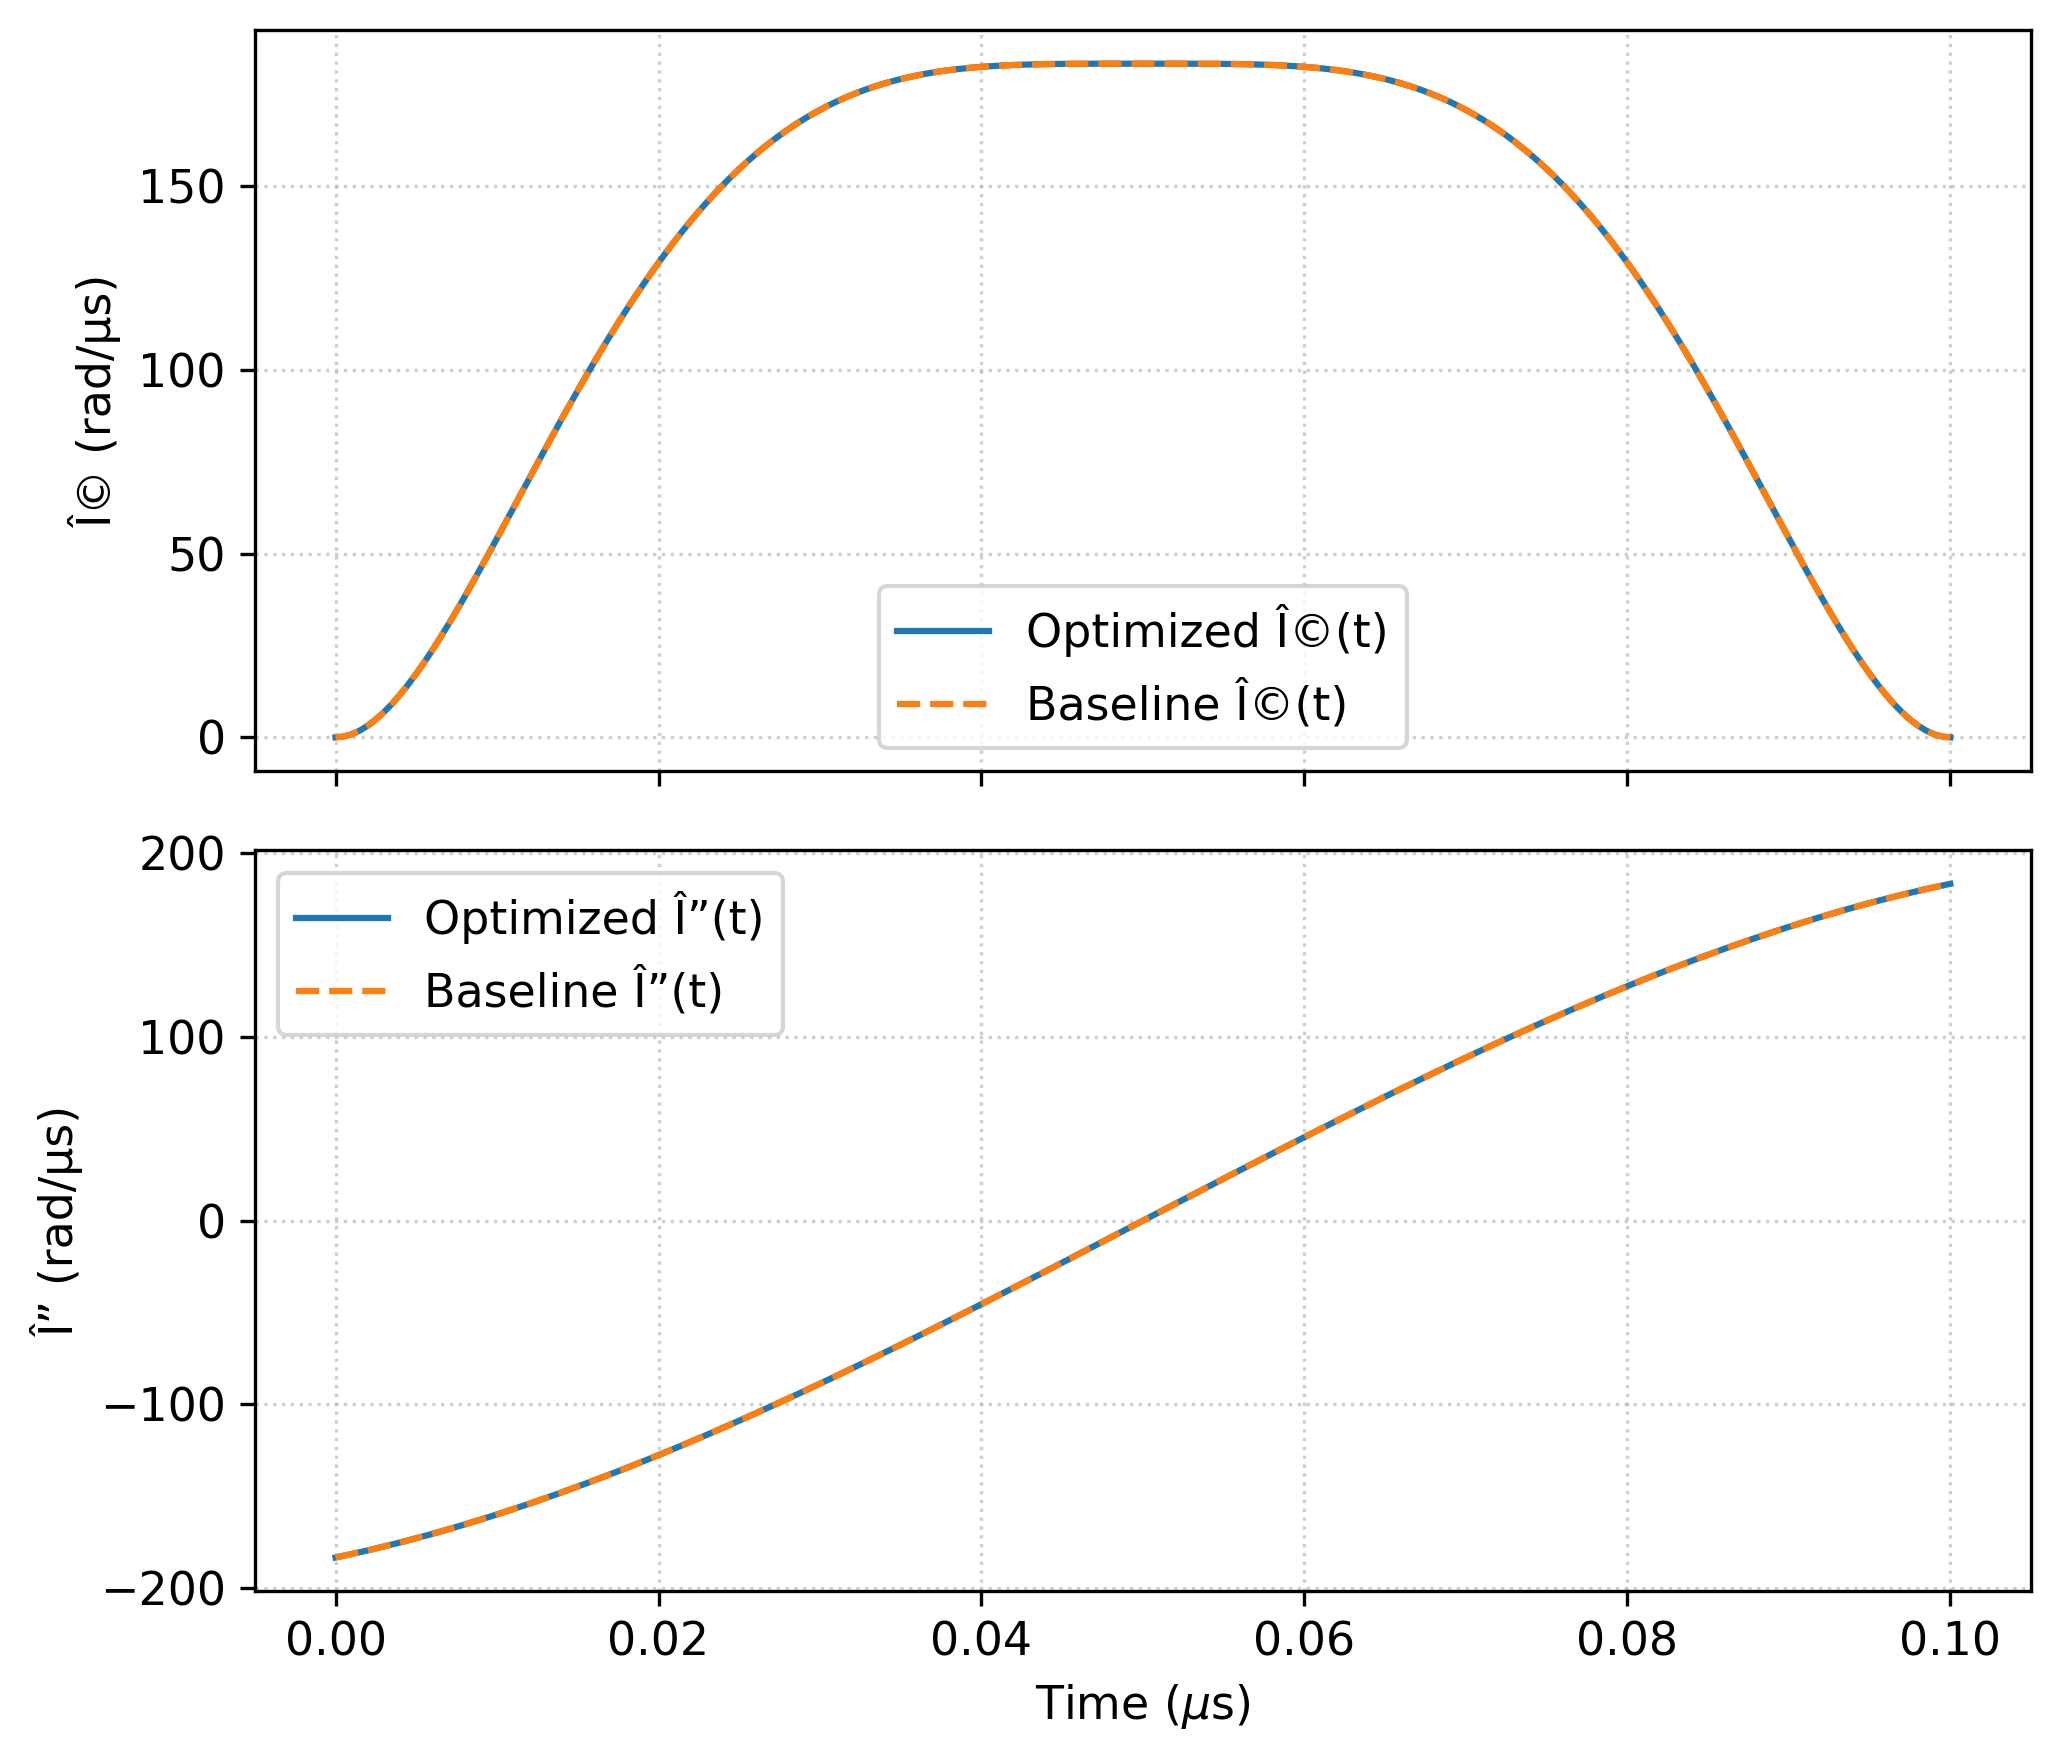

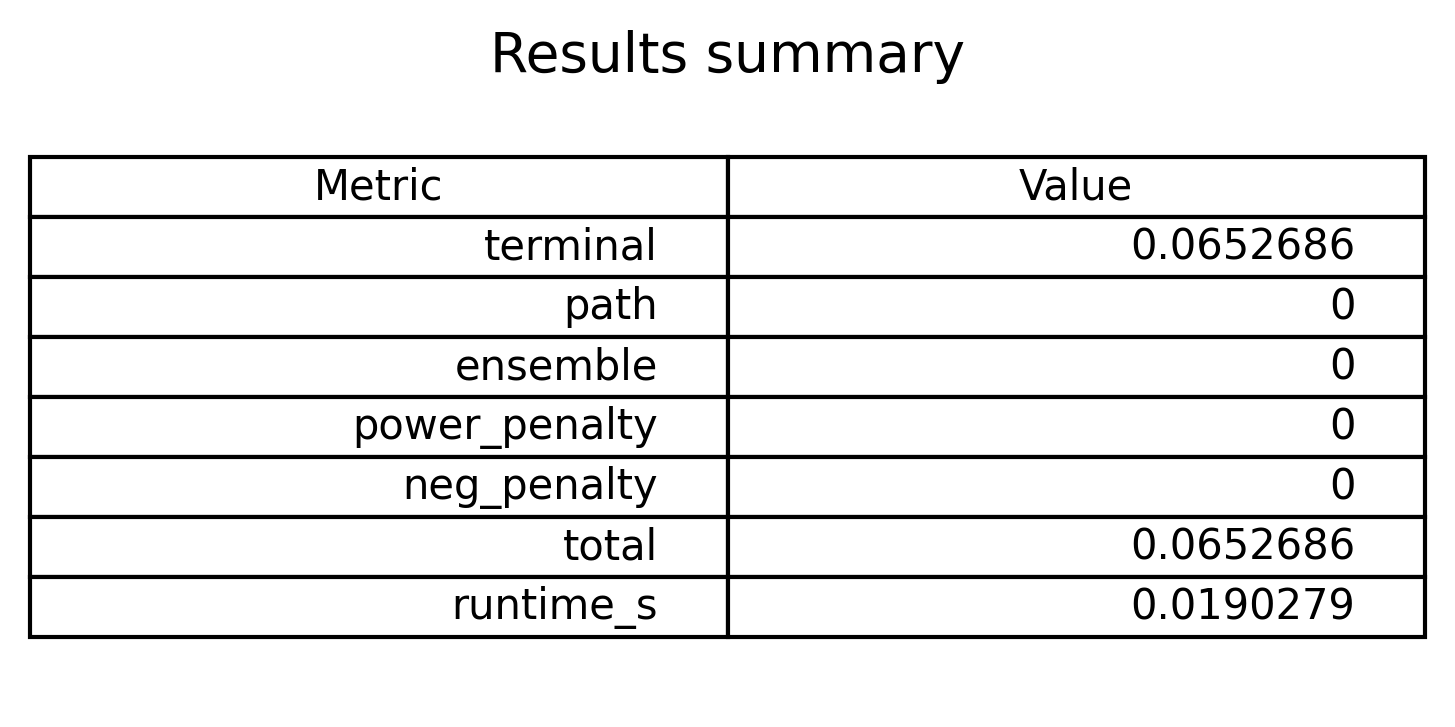

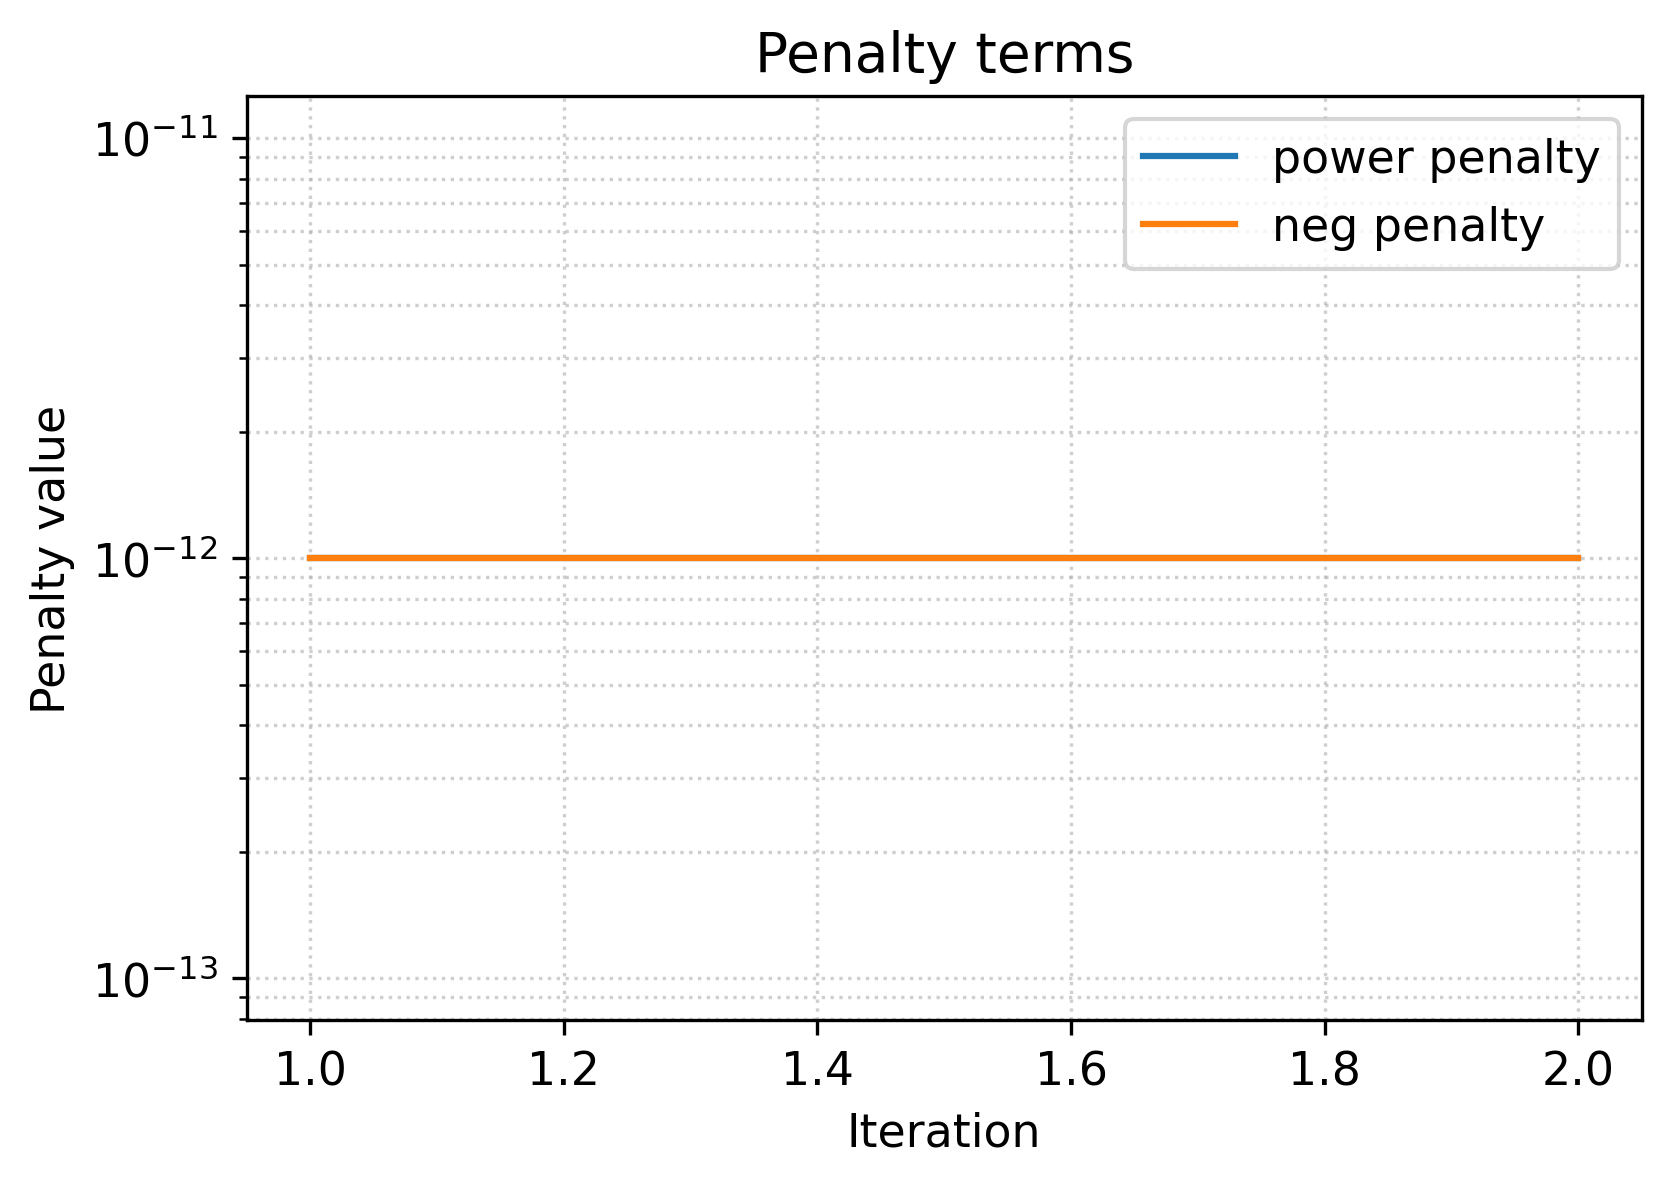

In [4]:
# @title Standard Figures
export_records = []
plt.rcParams.update({'figure.dpi': 300, 'font.size': 11})

for name, result in loaded_results.items():
    figures_dir = result.artifacts_dir / 'figures'
    figures_dir.mkdir(parents=True, exist_ok=True)
    plot_cost_history(result, save=True)
    plot_pulses(result, save=True)
    plot_summary(result, save=True)
    try:
        plot_penalties_history(result, save=True)
    except ValueError:
        pass

    for stem in ['cost_history', 'pulses', 'summary', 'penalties_history']:
        png = figures_dir / f'{stem}.png'
        svg = figures_dir / f'{stem}.svg'
        target_png = FIGURES_DIR / f'{name}_{stem}.png'
        target_svg = FIGURES_DIR / f'{name}_{stem}.svg'
        if png.exists():
            shutil.copy2(png, target_png)
            export_records.append((target_png, 'PNG', 300))
        if svg.exists():
            shutil.copy2(svg, target_svg)
            export_records.append((target_svg, 'SVG', None))
    print(f"Exported standard figures for {name} -> {FIGURES_DIR}")


## High-Resolution Robustness


High-resolution heatmaps saved to: C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\results\publication_figures\figures\heatmap_terminal_vs_detuning_area_4panel_highres.png


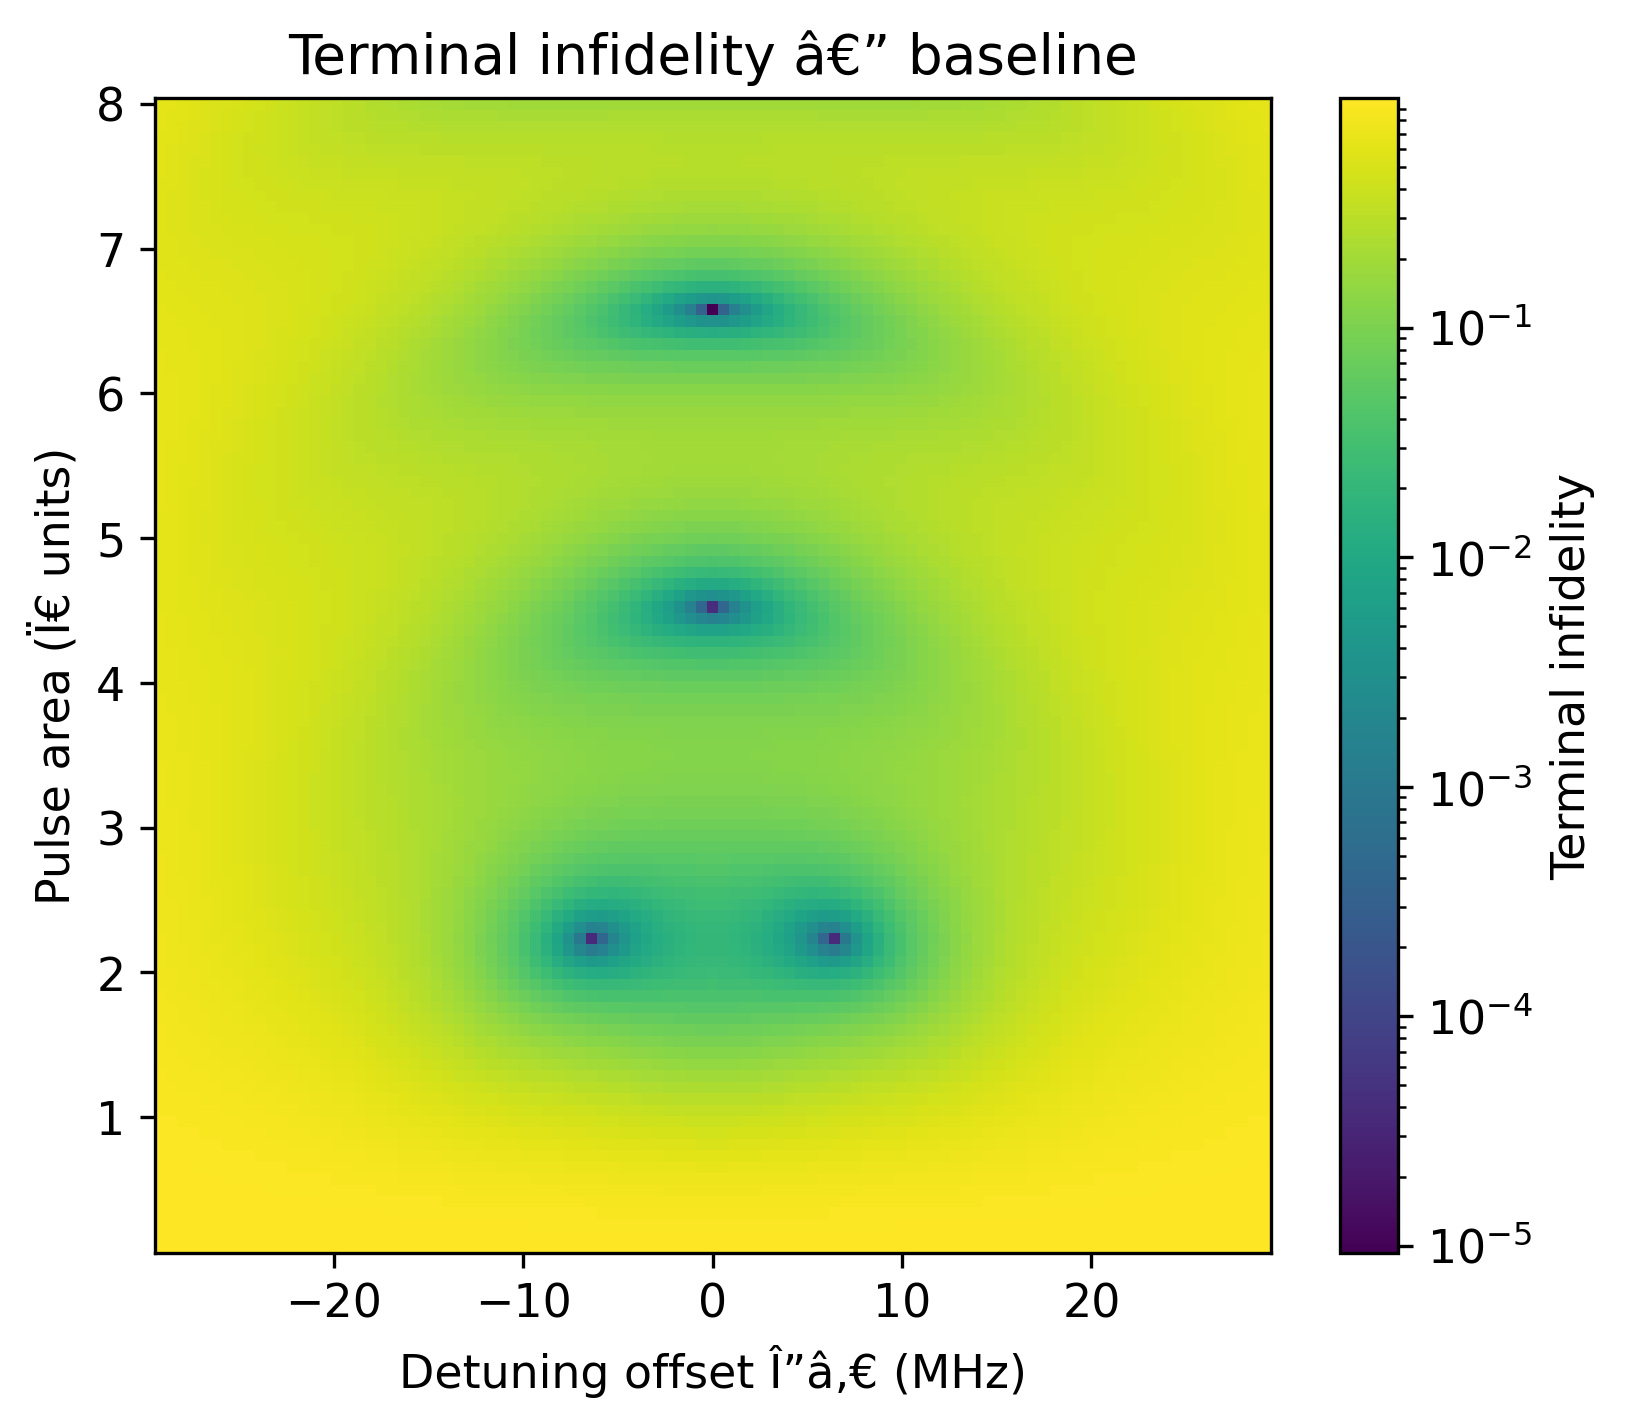

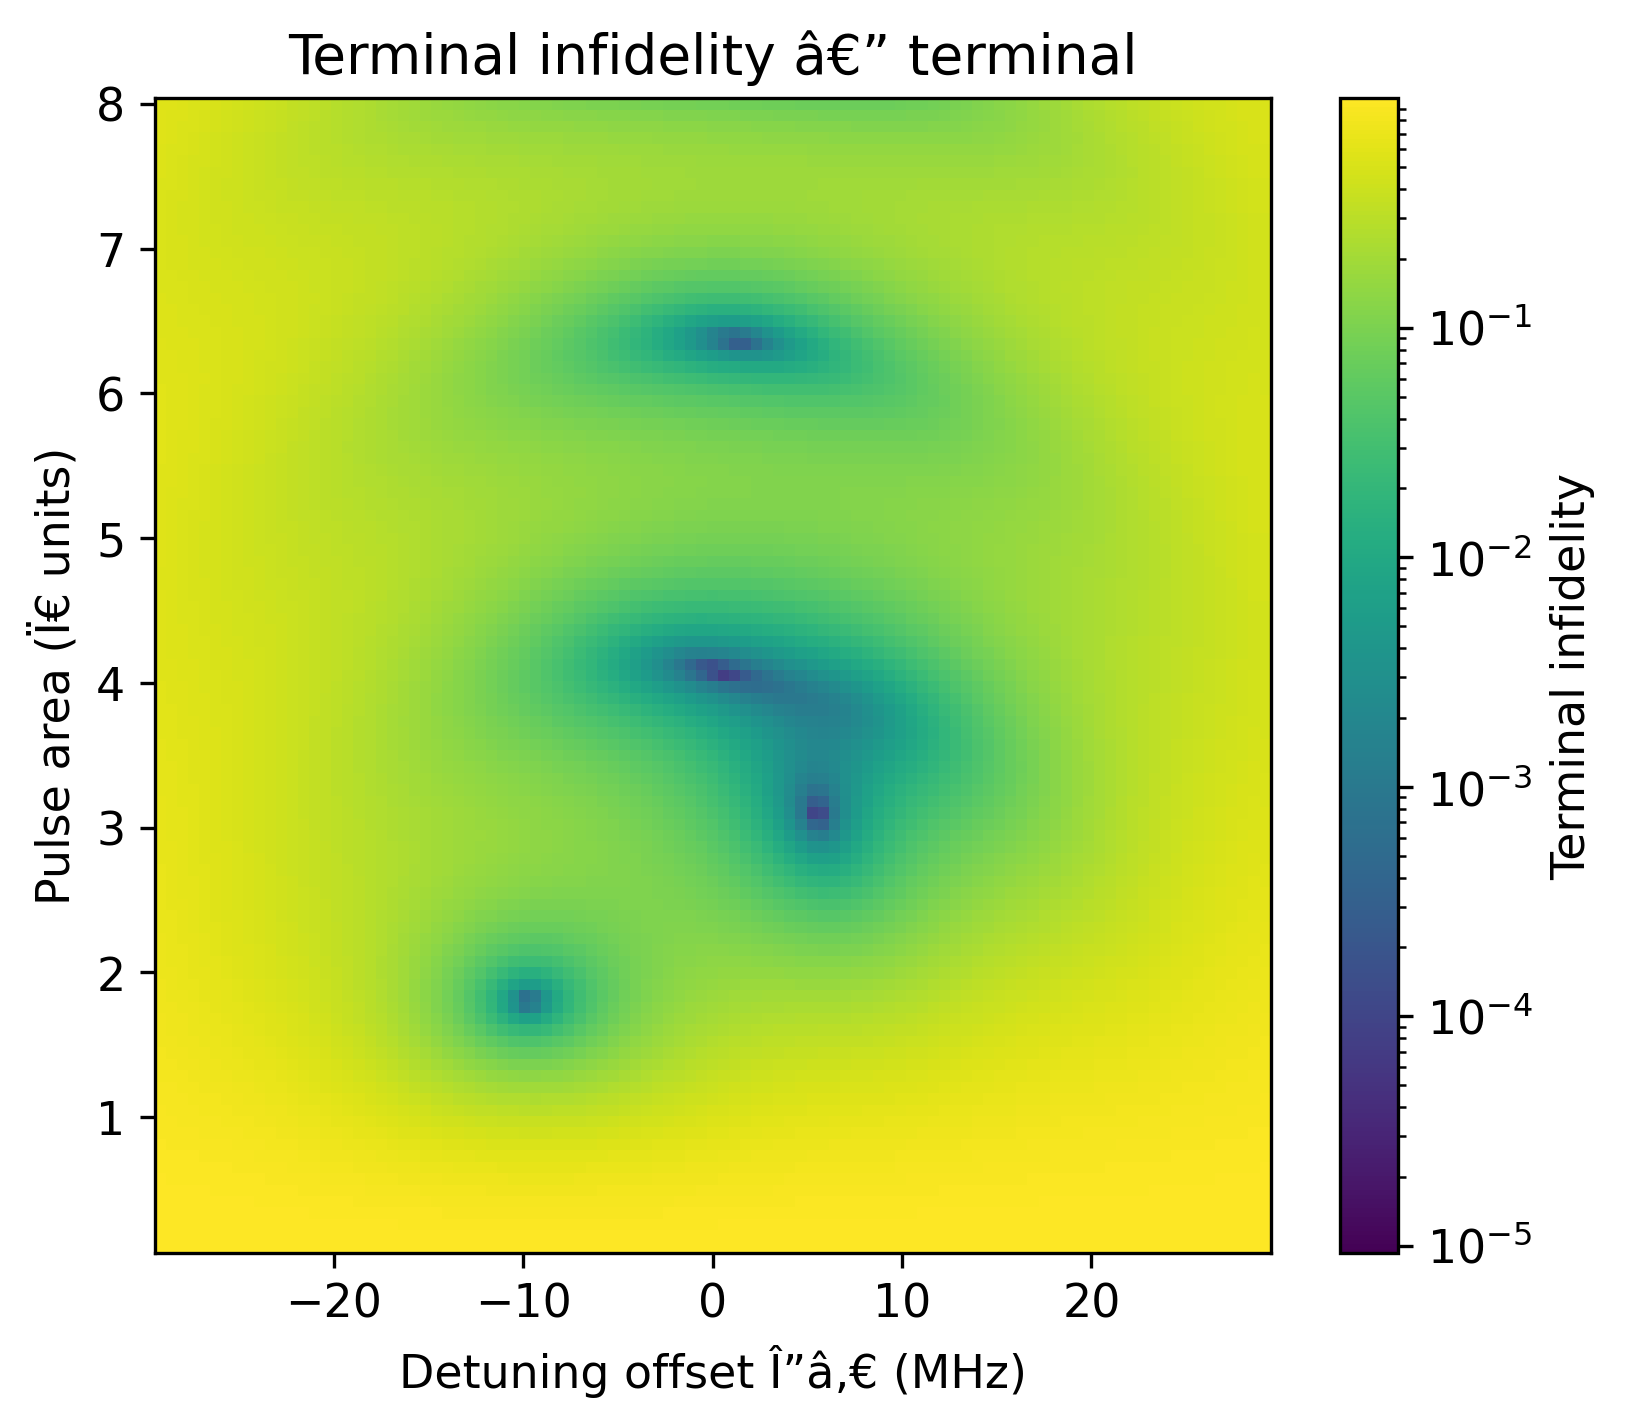

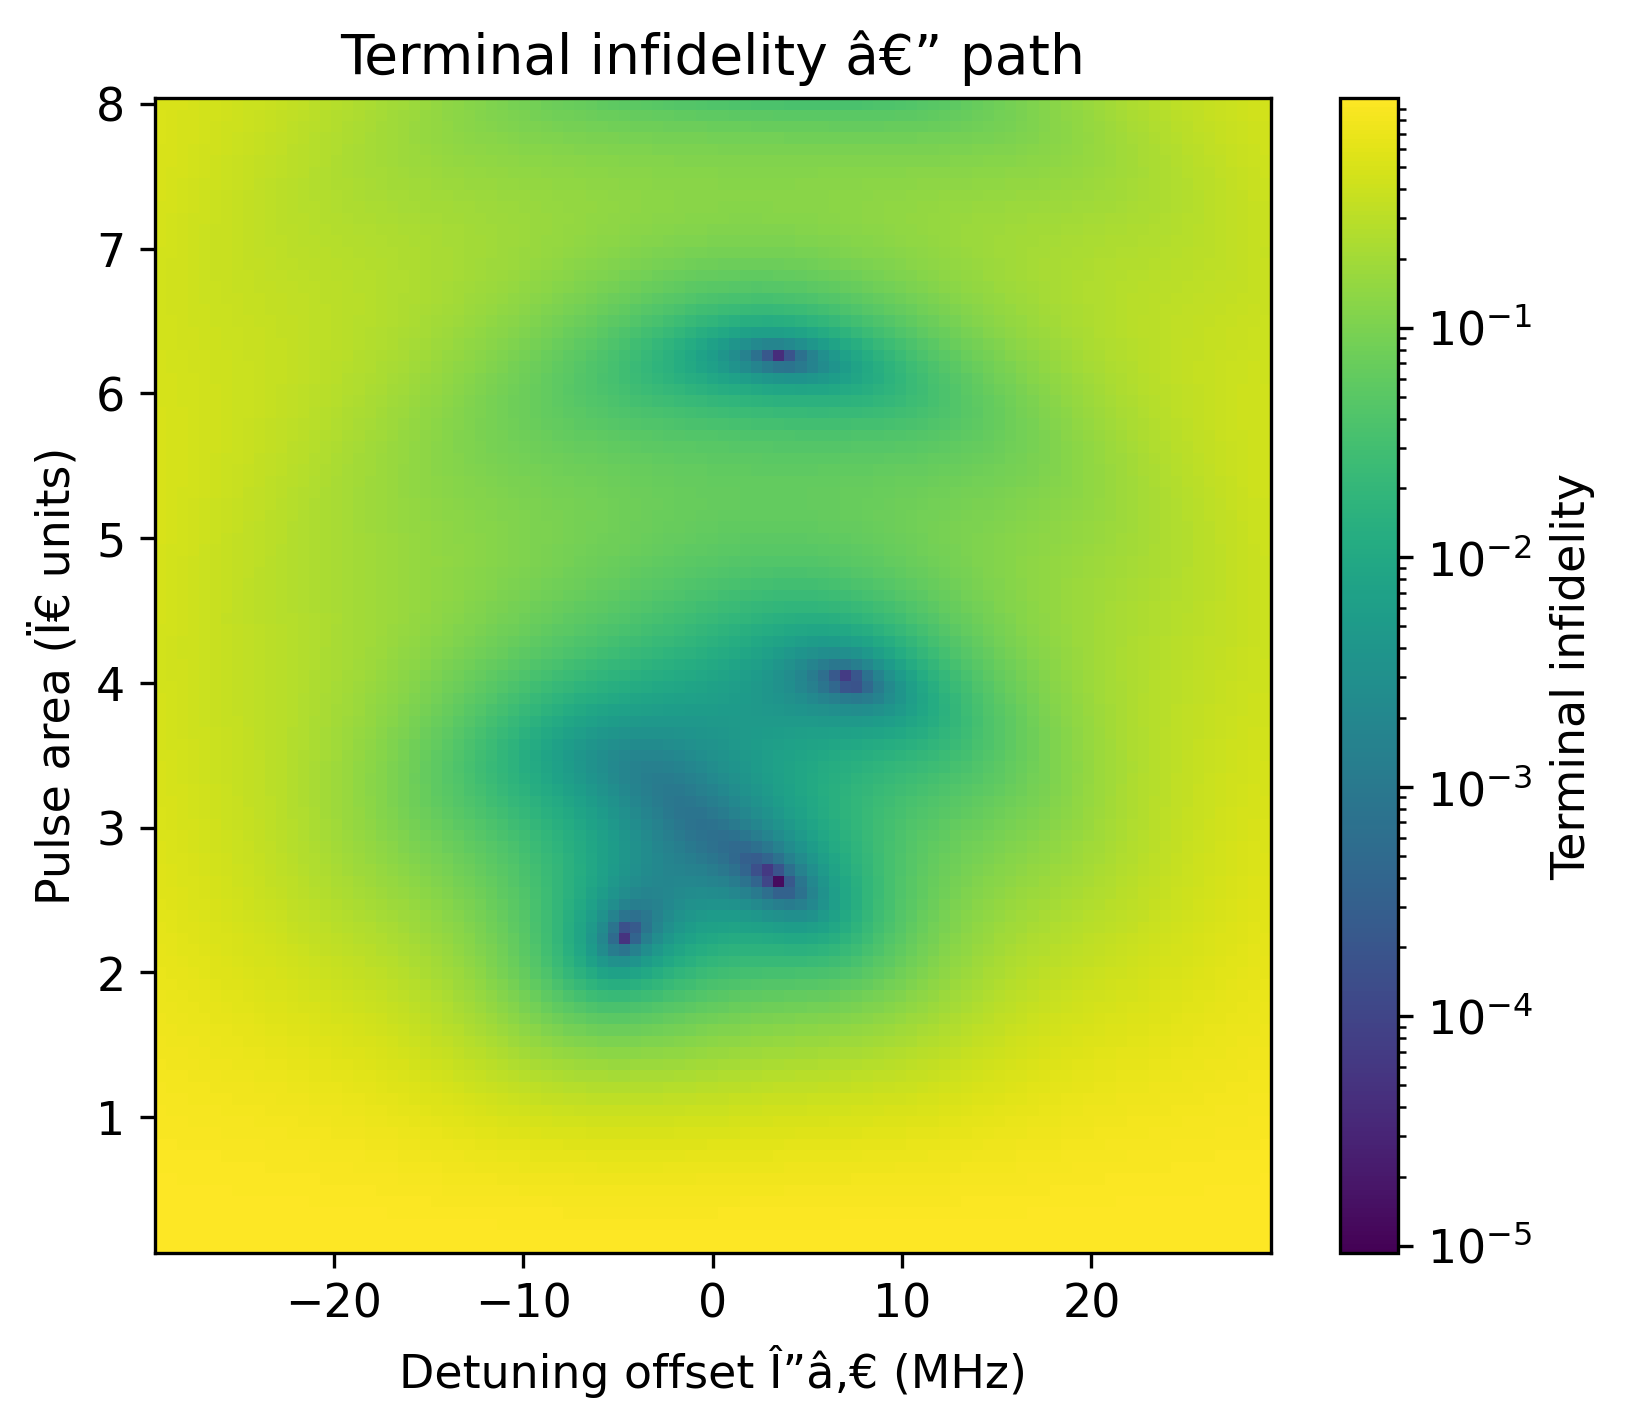

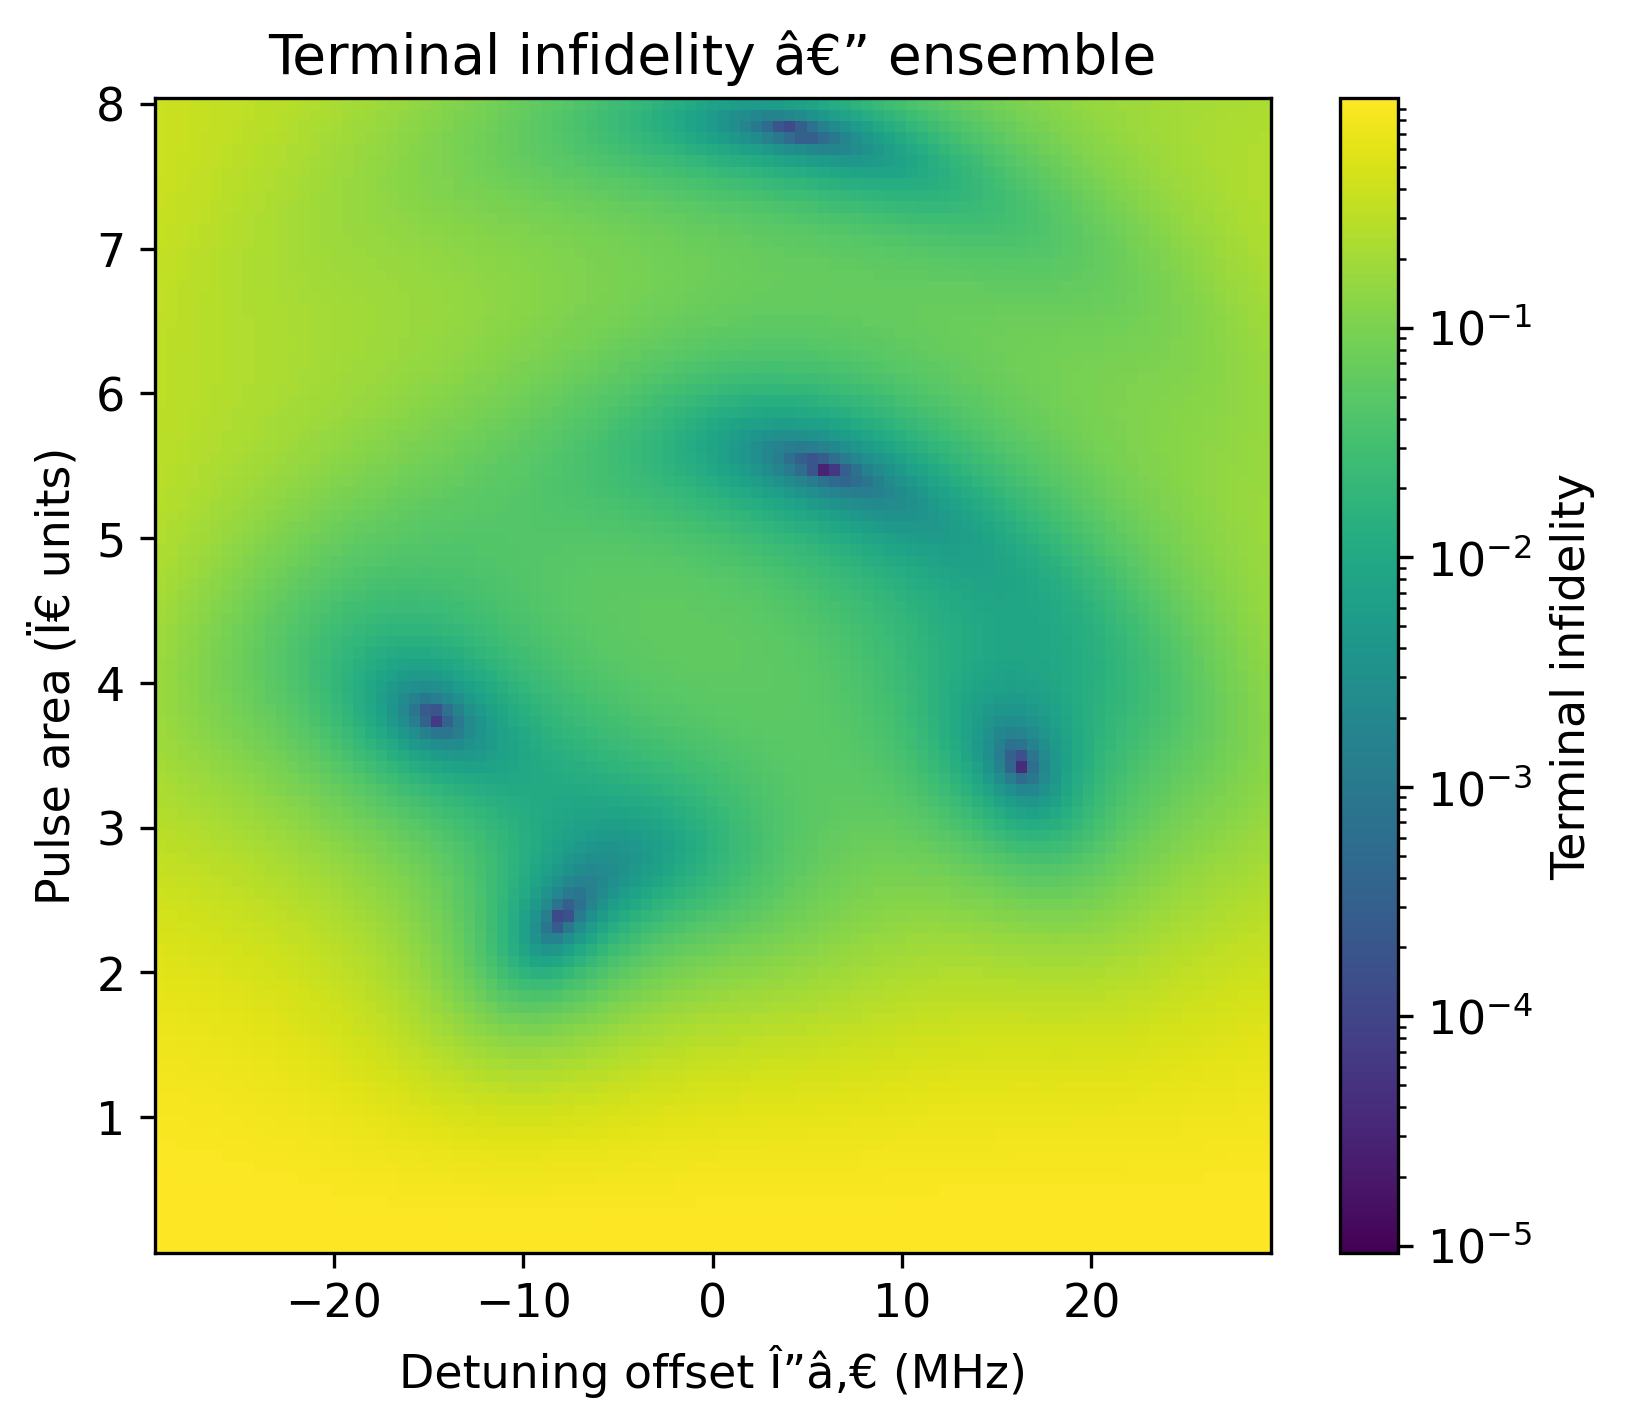

In [5]:
# @title High-Resolution Robustness
psi0 = baseline_problem.psi0
psi_target = baseline_problem.psi_target

delta_max_rad = float(np.abs(delta_baseline).max())
detuning_MHz_grid = np.linspace(-delta_max_rad / (2 * np.pi), delta_max_rad / (2 * np.pi), 101)
area_pi_grid = np.linspace(0.1, 8.0, 101)

selection = {
    'baseline': {'omega': omega_baseline, 'delta': delta_baseline, 'title': 'Baseline'},
}

terminal_candidates = []
for name, result in loaded_results.items():
    obj = result.config.metadata.get('objective', 'terminal')
    omega = np.asarray(result.pulses['omega'], dtype=float)
    delta = np.asarray(result.pulses.get('delta', delta_baseline), dtype=float)
    cost_eval, _ = accumulate_cost_and_grads(
        omega,
        delta,
        baseline_problem.dt_us,
        psi0=psi0,
        psi_target=psi_target,
        w_power=0.0,
        w_neg=0.0,
    )
    terminal_value = float(cost_eval.get('terminal', np.nan))
    if obj == 'terminal':
        terminal_candidates.append((terminal_value, name, omega, delta))
    elif obj == 'path':
        selection['path'] = {'omega': omega, 'delta': delta, 'title': f'Path optimised ({name})'}
    elif obj == 'ensemble':
        selection['ensemble'] = {'omega': omega, 'delta': delta, 'title': f'Ensemble optimised ({name})'}

if terminal_candidates:
    terminal_candidates.sort(key=lambda item: item[0])
    _, best_name, best_omega, best_delta = terminal_candidates[0]
    selection['terminal'] = {'omega': best_omega, 'delta': best_delta, 'title': f'Terminal optimised ({best_name})'}
else:
    any_terminal = next(iter(loaded_results.items()))
    omega = np.asarray(any_terminal[1].pulses['omega'], dtype=float)
    delta = np.asarray(any_terminal[1].pulses.get('delta', delta_baseline), dtype=float)
    selection['terminal'] = {'omega': omega, 'delta': delta, 'title': f'Terminal ({any_terminal[0]})'}

for key in ['path', 'ensemble']:
    if key not in selection:
        selection[key] = selection['baseline']

panel_order = [('baseline', 'Baseline'), ('terminal', 'Terminal optimised'), ('path', 'Path optimised'), ('ensemble', 'Ensemble optimised')]

heatmap_data = {}
finite_vals = []
for label, title in panel_order:
    pulse = selection[label]
    ax, inf = plot_robustness_heatmap(
        {'omega': pulse['omega'], 'delta': pulse['delta']},
        baseline_problem.t_us,
        delta_baseline,
        detuning_MHz_grid,
        area_pi_grid,
        label=label,
        psi0=psi0,
        target=psi_target,
        save_dir=FIGURES_DIR,
        save=False,
    )
    heatmap_data[label] = inf
    plt.close(ax.figure)
    finite = inf[np.isfinite(inf) & (inf > 0.0)]
    if finite.size:
        finite_vals.append(finite.min())
        finite_vals.append(finite.max())

if finite_vals:
    vmin = min(finite_vals)
    vmax = max(finite_vals)
else:
    vmin, vmax = 1e-6, 1.0

for label, title in panel_order:
    pulse = selection[label]
    plot_robustness_heatmap(
        {'omega': pulse['omega'], 'delta': pulse['delta']},
        baseline_problem.t_us,
        delta_baseline,
        detuning_MHz_grid,
        area_pi_grid,
        label=label,
        psi0=psi0,
        target=psi_target,
        save_dir=FIGURES_DIR,
        save=True,
        vmin=vmin,
        vmax=vmax,
    )

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
axes = axes.flatten()
for ax, (label, title) in zip(axes, panel_order):
    inf = heatmap_data[label]
    X, Y = np.meshgrid(detuning_MHz_grid, area_pi_grid)
    mesh = ax.pcolormesh(X, Y, inf, shading='auto', cmap='viridis', norm=LogNorm(vmin=max(vmin, 1e-8), vmax=max(vmax, 1e-6)))
    ax.set_title(title)
    ax.set_xlabel('Detuning offset Δ₀ (MHz)')
    ax.set_ylabel('Pulse area (π units)')

fig.subplots_adjust(right=0.88, hspace=0.25)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
fig.colorbar(mesh, cax=cbar_ax).set_label('Terminal infidelity')
combined_png = FIGURES_DIR / 'heatmap_terminal_vs_detuning_area_4panel_highres.png'
combined_svg = FIGURES_DIR / 'heatmap_terminal_vs_detuning_area_4panel_highres.svg'
fig.savefig(combined_png, dpi=300, bbox_inches='tight')
fig.savefig(combined_svg, bbox_inches='tight')
plt.close(fig)

export_records.append((combined_png, 'PNG', 300))
export_records.append((combined_svg, 'SVG', None))

print('High-resolution heatmaps saved to:', combined_png)


## Export Summary


In [6]:
# @title Export Summary
from pathlib import Path

print('Exported figures:')
for path, kind, dpi in export_records:
    if not Path(path).exists():
        continue
    size_kb = Path(path).stat().st_size / 1024
    if dpi is None:
        print(f"  {path} ({kind}, {size_kb:.1f} kB)")
    else:
        print(f"  {path} ({kind}, {dpi} dpi, {size_kb:.1f} kB)")


Exported figures:
  C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\results\publication_figures\figures\comparison-ensemble-adam-opt_cost_history.png (PNG, 300 dpi, 92.2 kB)
  C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\results\publication_figures\figures\comparison-ensemble-adam-opt_pulses.png (PNG, 300 dpi, 219.4 kB)
  C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\results\publication_figures\figures\comparison-ensemble-adam-opt_summary.png (PNG, 300 dpi, 62.1 kB)
  C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\results\publication_figures\figures\comparison-ensemble-adam-opt_penalties_history.png (PNG, 300 dpi, 75.2 kB)
  C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\results\publication_figures\figures\comparison-path-adam-opt_cost_history.png (PNG, 300 dpi, 83.5 kB)
  C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\results\publication_figures\figures\comparison-path-adam-opt_pulses.png (PNG, 300 dpi, 216.6 kB)
  C:\Users\yehon\Dropbox\Thesis\Projects

## Troubleshooting

- Missing artifact? Update `ARTIFACT_GLOBS` to point at the desired run directories.
- Penalty history absent? Some runs may not log penalties; the notebook skips gracefully.
- Colour scaling: adjust the `vmin`/`vmax` computation in the robustness cell for manual control.
- Fonts and figure sizes: tweak `plt.rcParams` near the top to match publication styling.
- Output cluttered? Change `OUTPUT_DIR` to keep batches separated.
